In [ ]:
#@title 1. Google Drive 연결
from google.colab import drive
drive.mount('/content/drive')

print("\n✅ Google Drive가 연결되었습니다.")

Mounted at /content/drive

✅ Google Drive가 연결되었습니다.


In [1]:
#@title 🏆 mo-thecreator 모델 - ASVspoof 2019 전체 평가

# ==================== 설치 및 임포트 ====================
print("=" * 60)
print("필수 라이브러리 설치 중...")
print("=" * 60)

!pip install -q transformers torch torchaudio librosa soundfile scikit-learn pandas matplotlib seaborn

import torch
from transformers import Wav2Vec2ForSequenceClassification, Wav2Vec2FeatureExtractor
import librosa
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
from sklearn.metrics import (
    accuracy_score, confusion_matrix, classification_report,
    roc_curve, auc, precision_recall_fscore_support
)
import matplotlib.pyplot as plt
import seaborn as sns
import os
from google.colab import drive
import warnings
import time
warnings.filterwarnings('ignore')

print("✅ 라이브러리 설치 완료!")
print(f"PyTorch: {torch.__version__}")
print(f"CUDA 사용 가능: {torch.cuda.is_available()}")

# ==================== Google Drive 마운트 ====================
print("\n" + "=" * 60)
print("Google Drive 마운트 중...")
print("=" * 60)
try:
    drive.mount('/content/drive')
    print("✅ Google Drive 마운트 완료!")
except Exception as e:
    print(f"❌ Google Drive 마운트 실패: {e}")

# ==================== mo-thecreator 모델 로드 ====================
print("\n" + "=" * 60)
print("mo-thecreator 모델 로드 중...")
print("=" * 60)

MODEL_NAME = "mo-thecreator/Deepfake-audio-detection"

print(f"모델: {MODEL_NAME}")
print("다운로드 중... (처음 실행 시 1-2분 소요)")

try:
    feature_extractor = Wav2Vec2FeatureExtractor.from_pretrained(MODEL_NAME)
    model = Wav2Vec2ForSequenceClassification.from_pretrained(MODEL_NAME)

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)
    model.eval()

    print(f"✅ 모델 로드 완료! (Device: {device})")
    print(f"\n📊 모델 설정:")
    print(f"   - num_labels: {model.config.num_labels}")
    if hasattr(model.config, 'id2label'):
        print(f"   - id2label: {model.config.id2label}")
    if hasattr(model.config, 'label2id'):
        print(f"   - label2id: {model.config.label2id}")

except Exception as e:
    print(f"❌ 모델 로드 오류: {e}")
    model = None
    feature_extractor = None

# ==================== 경로 설정 및 정답지 로드 ====================
print("\n" + "=" * 60)
print("경로 설정 및 ASVspoof 2019 정답지 로드 중...")
print("=" * 60)

gdrive_base_path = "/content/drive/MyDrive/SeSAC/project/data"
eval_folder_path = os.path.join(gdrive_base_path, "ASVspoof2019_LA_eval")
metadata_path = os.path.join(gdrive_base_path, "ASVspoof2019_LA_cm_protocols/new_answer_sheet.txt")

try:
    metadata_df = pd.read_csv(metadata_path, sep=" ", header=None)
    metadata_df.columns = ["speaker_id", "filename", "dash", "attack_type", "label"]
    answer_key = pd.Series(metadata_df.label.values, index=metadata_df.filename).to_dict()

    total_count = len(answer_key)
    bonafide_count = sum(1 for v in answer_key.values() if v == 'bonafide')
    spoof_count = sum(1 for v in answer_key.values() if v == 'spoof')

    print(f"✅ 정답지 로드 완료!")
    print(f"   - 전체: {total_count:,}개")
    print(f"   - Bonafide (진짜): {bonafide_count:,}개 ({bonafide_count/total_count*100:.1f}%)")
    print(f"   - Spoof (가짜): {spoof_count:,}개 ({spoof_count/total_count*100:.1f}%)")
    print(f"   - 데이터 폴더: {eval_folder_path}")
except Exception as e:
    print(f"❌ 정답지 로드 오류: {e}")
    answer_key = {}

# ==================== 전체 데이터셋 평가 (확률 수집) ====================
print("\n" + "=" * 60)
print("전체 데이터셋 평가 시작")
print("=" * 60)

if model and feature_extractor and answer_key:
    results_list = []
    failed_files = []

    start_time = time.time()
    print(f"📊 총 {len(answer_key):,}개 파일 평가 중...")
    print("=" * 60)

    for idx, (filename, true_label_str) in enumerate(tqdm(answer_key.items(), desc="추론 중"), 1):
        file_path = os.path.join(eval_folder_path, f"{filename}.flac")

        try:
            # 오디오 로드
            audio, sr = librosa.load(file_path, sr=16000)

            # Feature extraction
            inputs = feature_extractor(
                audio,
                sampling_rate=16000,
                return_tensors="pt",
                padding=True,
                max_length=16000 * 10,
                truncation=True
            )
            input_values = inputs.input_values.to(device)

            # 예측
            with torch.no_grad():
                outputs = model(input_values)
                logits = outputs.logits
                probs = torch.nn.functional.softmax(logits, dim=-1)[0]

                # 레이블 방향에 따라
                fake_prob = probs[fake_idx].item()
                real_prob = probs[real_idx].item()

            results_list.append({
                "filename": filename,
                "true_label": true_label_str,
                "fake_probability": fake_prob,
                "real_probability": real_prob,
                "attack_type": metadata_df[metadata_df['filename'] == filename]['attack_type'].values[0]
            })

        except FileNotFoundError:
            failed_files.append((filename, "파일 없음"))
            continue
        except Exception as e:
            failed_files.append((filename, str(e)))
            continue

        # 중간 진행 상황 (매 500개)
        if idx % 500 == 0:
            elapsed = time.time() - start_time
            speed = idx / elapsed
            remaining = (len(answer_key) - idx) / speed
            print(f"\n진행: {idx:,}/{len(answer_key):,} ({idx/len(answer_key)*100:.1f}%) | "
                  f"속도: {speed:.1f}개/초 | 예상 남은 시간: {remaining/60:.1f}분")

    elapsed_time = time.time() - start_time

    results_df = pd.DataFrame(results_list)

    print(f"\n✅ 평가 완료!")
    print(f"   - 성공: {len(results_df):,}개")
    print(f"   - 실패: {len(failed_files)}개")
    print(f"   - 소요 시간: {elapsed_time/60:.1f}분")
    print(f"   - 평균 속도: {len(results_df)/elapsed_time:.1f}개/초")

    if failed_files:
        print(f"\n⚠️ 실패한 파일들 (처음 10개):")
        for filename, error in failed_files[:10]:
            print(f"   - {filename}: {error}")

# ==================== 확률 분포 분석 ====================
print("\n" + "=" * 60)
print("확률 분포 분석")
print("=" * 60)

if not results_df.empty:
    label_mapping = {'bonafide': 0, 'spoof': 1}
    results_df['y_true_numeric'] = results_df['true_label'].map(label_mapping)

    bonafide_df = results_df[results_df['true_label'] == 'bonafide']
    spoof_df = results_df[results_df['true_label'] == 'spoof']

    print(f"\n📊 Fake 확률 분포 통계:")
    print(f"  Bonafide (진짜):")
    print(f"    - 평균: {bonafide_df['fake_probability'].mean():.4f}")
    print(f"    - 중간값: {bonafide_df['fake_probability'].median():.4f}")
    print(f"    - 표준편차: {bonafide_df['fake_probability'].std():.4f}")
    print(f"    - 최소: {bonafide_df['fake_probability'].min():.4f}")
    print(f"    - 최대: {bonafide_df['fake_probability'].max():.4f}")

    print(f"\n  Spoof (가짜):")
    print(f"    - 평균: {spoof_df['fake_probability'].mean():.4f}")
    print(f"    - 중간값: {spoof_df['fake_probability'].median():.4f}")
    print(f"    - 표준편차: {spoof_df['fake_probability'].std():.4f}")
    print(f"    - 최소: {spoof_df['fake_probability'].min():.4f}")
    print(f"    - 최대: {spoof_df['fake_probability'].max():.4f}")

    # 시각화
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))

    # 1. Fake 확률 분포 (히스토그램)
    axes[0, 0].hist(bonafide_df['fake_probability'], bins=50, alpha=0.6,
                    label='Bonafide (진짜)', color='green', density=True)
    axes[0, 0].hist(spoof_df['fake_probability'], bins=50, alpha=0.6,
                    label='Spoof (가짜)', color='red', density=True)
    axes[0, 0].set_xlabel('Fake Probability')
    axes[0, 0].set_ylabel('Density')
    axes[0, 0].set_title('Fake 확률 분포')
    axes[0, 0].legend()
    axes[0, 0].grid(alpha=0.3)

    # 2. 박스플롯
    data_for_box = [bonafide_df['fake_probability'], spoof_df['fake_probability']]
    axes[0, 1].boxplot(data_for_box, labels=['Bonafide', 'Spoof'])
    axes[0, 1].set_ylabel('Fake Probability')
    axes[0, 1].set_title('Fake 확률 박스플롯')
    axes[0, 1].grid(alpha=0.3)

    # 3. ROC Curve
    fpr, tpr, thresholds = roc_curve(results_df['y_true_numeric'],
                                      results_df['fake_probability'])
    roc_auc = auc(fpr, tpr)

    axes[1, 0].plot(fpr, tpr, color='darkorange', lw=2,
                    label=f'ROC curve (AUC = {roc_auc:.4f})')
    axes[1, 0].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    axes[1, 0].set_xlim([0.0, 1.0])
    axes[1, 0].set_ylim([0.0, 1.05])
    axes[1, 0].set_xlabel('False Positive Rate')
    axes[1, 0].set_ylabel('True Positive Rate')
    axes[1, 0].set_title(f'ROC Curve (AUC = {roc_auc:.4f})')
    axes[1, 0].legend(loc="lower right")
    axes[1, 0].grid(alpha=0.3)

    # 4. Attack Type별 성능
    if 'attack_type' in results_df.columns:
        attack_types = spoof_df['attack_type'].value_counts().head(10)
        axes[1, 1].barh(range(len(attack_types)), attack_types.values)
        axes[1, 1].set_yticks(range(len(attack_types)))
        axes[1, 1].set_yticklabels(attack_types.index)
        axes[1, 1].set_xlabel('Count')
        axes[1, 1].set_title('Top 10 Attack Types')
        axes[1, 1].grid(alpha=0.3, axis='x')

    plt.tight_layout()
    plt.savefig('probability_distribution.png', dpi=300, bbox_inches='tight')
    plt.show()

    print(f"\n💾 그래프 저장: probability_distribution.png")

# ==================== 8. 임계값 최적화 ====================
print("\n" + "=" * 60)
print("임계값 최적화")
print("=" * 60)

if not results_df.empty:
    thresholds_to_test = np.arange(0.05, 0.95, 0.05)
    threshold_results = []

    for thresh in thresholds_to_test:
        y_pred = (results_df['fake_probability'] >= thresh).astype(int)
        y_true = results_df['y_true_numeric']

        acc = accuracy_score(y_true, y_pred)
        cm = confusion_matrix(y_true, y_pred, labels=[0, 1])

        if cm.size == 4:
            tn, fp, fn, tp = cm.ravel()

            precision = tp / (tp + fp) if (tp + fp) > 0 else 0
            recall = tp / (tp + fn) if (tp + fn) > 0 else 0
            f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

            # FAR, FRR, EER 계산
            far = fp / (fp + tn) if (fp + tn) > 0 else 0  # False Acceptance Rate
            frr = fn / (fn + tp) if (fn + tp) > 0 else 0  # False Rejection Rate
            eer_diff = abs(far - frr)

            threshold_results.append({
                'threshold': thresh,
                'accuracy': acc,
                'precision': precision,
                'recall': recall,
                'f1': f1,
                'far': far,
                'frr': frr,
                'eer_diff': eer_diff,
                'tp': tp, 'fp': fp, 'tn': tn, 'fn': fn
            })

    threshold_df = pd.DataFrame(threshold_results)

    # 최적 임계값들
    best_acc_idx = threshold_df['accuracy'].idxmax()
    best_f1_idx = threshold_df['f1'].idxmax()
    best_eer_idx = threshold_df['eer_diff'].idxmin()

    print("\n🎯 최적 임계값 후보:")
    print(f"\n1. 최고 정확도 (Accuracy):")
    print(f"   Threshold: {threshold_df.loc[best_acc_idx, 'threshold']:.2f}")
    print(f"   Accuracy: {threshold_df.loc[best_acc_idx, 'accuracy']:.4%}")
    print(f"   F1 Score: {threshold_df.loc[best_acc_idx, 'f1']:.4f}")
    print(f"   FAR: {threshold_df.loc[best_acc_idx, 'far']:.4%}")
    print(f"   FRR: {threshold_df.loc[best_acc_idx, 'frr']:.4%}")

    print(f"\n2. 최고 F1 Score:")
    print(f"   Threshold: {threshold_df.loc[best_f1_idx, 'threshold']:.2f}")
    print(f"   Accuracy: {threshold_df.loc[best_f1_idx, 'accuracy']:.4%}")
    print(f"   F1 Score: {threshold_df.loc[best_f1_idx, 'f1']:.4f}")
    print(f"   FAR: {threshold_df.loc[best_f1_idx, 'far']:.4%}")
    print(f"   FRR: {threshold_df.loc[best_f1_idx, 'frr']:.4%}")

    print(f"\n3. 최소 EER (Equal Error Rate):")
    print(f"   Threshold: {threshold_df.loc[best_eer_idx, 'threshold']:.2f}")
    print(f"   Accuracy: {threshold_df.loc[best_eer_idx, 'accuracy']:.4%}")
    print(f"   F1 Score: {threshold_df.loc[best_eer_idx, 'f1']:.4f}")
    print(f"   FAR: {threshold_df.loc[best_eer_idx, 'far']:.4%}")
    print(f"   FRR: {threshold_df.loc[best_eer_idx, 'frr']:.4%}")

    # 시각화
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))

    axes[0, 0].plot(threshold_df['threshold'], threshold_df['accuracy'], 'b-', lw=2)
    axes[0, 0].axvline(threshold_df.loc[best_acc_idx, 'threshold'],
                      color='r', linestyle='--', label='Best')
    axes[0, 0].set_xlabel('Threshold')
    axes[0, 0].set_ylabel('Accuracy')
    axes[0, 0].set_title('Accuracy vs Threshold')
    axes[0, 0].legend()
    axes[0, 0].grid(alpha=0.3)

    axes[0, 1].plot(threshold_df['threshold'], threshold_df['f1'], 'g-', lw=2)
    axes[0, 1].axvline(threshold_df.loc[best_f1_idx, 'threshold'],
                      color='r', linestyle='--', label='Best')
    axes[0, 1].set_xlabel('Threshold')
    axes[0, 1].set_ylabel('F1 Score')
    axes[0, 1].set_title('F1 Score vs Threshold')
    axes[0, 1].legend()
    axes[0, 1].grid(alpha=0.3)

    axes[1, 0].plot(threshold_df['threshold'], threshold_df['far'],
                   'b-', lw=2, label='FAR')
    axes[1, 0].plot(threshold_df['threshold'], threshold_df['frr'],
                   'r-', lw=2, label='FRR')
    axes[1, 0].axvline(threshold_df.loc[best_eer_idx, 'threshold'],
                      color='g', linestyle='--', label='EER Point')
    axes[1, 0].set_xlabel('Threshold')
    axes[1, 0].set_ylabel('Error Rate')
    axes[1, 0].set_title('FAR & FRR vs Threshold')
    axes[1, 0].legend()
    axes[1, 0].grid(alpha=0.3)

    axes[1, 1].plot(threshold_df['threshold'], threshold_df['precision'],
                   'b-', lw=2, label='Precision')
    axes[1, 1].plot(threshold_df['threshold'], threshold_df['recall'],
                   'r-', lw=2, label='Recall')
    axes[1, 1].set_xlabel('Threshold')
    axes[1, 1].set_ylabel('Score')
    axes[1, 1].set_title('Precision & Recall vs Threshold')
    axes[1, 1].legend()
    axes[1, 1].grid(alpha=0.3)

    plt.tight_layout()
    plt.savefig('threshold_analysis.png', dpi=300, bbox_inches='tight')
    plt.show()

    print(f"\n💾 그래프 저장: threshold_analysis.png")

# ==================== 최종 평가 (최적 임계값 사용) ====================
print("\n" + "=" * 60)
print("최종 평가 결과")
print("=" * 60)

if not results_df.empty:
    # F1 Score가 가장 높은 임계값 사용
    OPTIMAL_THRESHOLD = threshold_df.loc[best_f1_idx, 'threshold']

    y_pred = (results_df['fake_probability'] >= OPTIMAL_THRESHOLD).astype(int)
    y_true = results_df['y_true_numeric']

    results_df['predicted_label'] = y_pred.apply(lambda x: 'spoof' if x == 1 else 'bonafide')
    results_df['is_correct'] = (results_df['true_label'] == results_df['predicted_label'])

    accuracy = accuracy_score(y_true, y_pred)
    cm = confusion_matrix(y_true, y_pred, labels=[0, 1])

    print(f"\n✅ 최적 임계값: {OPTIMAL_THRESHOLD:.2f}")
    print(f"\n📊 전체 정확도 (Accuracy): {accuracy:.4%}")
    print(f"\n📊 혼동 행렬 (Confusion Matrix):")

    if cm.size == 4:
        tn, fp, fn, tp = cm.ravel()
        print("                  예측: 진짜(BNF)  예측: 가짜(SPF)")
        print(f"실제: 진짜(BNF)    {tn:<10}    {fp:<10}")
        print(f"실제: 가짜(SPF)    {fn:<10}    {tp:<10}")
        print(f"\n상세 결과:")
        print(f"  - True Positive (TP): {tp:4d} - 가짜를 가짜로 올바르게 판정")
        print(f"  - True Negative (TN): {tn:4d} - 진짜를 진짜로 올바르게 판정")
        print(f"  - False Positive (FP): {fp:4d} - 진짜를 가짜로 잘못 판정 (❌ 중요!)")
        print(f"  - False Negative (FN): {fn:4d} - 가짜를 진짜로 잘못 판정 (❌ 위험!)")

        # 추가 메트릭
        precision = tp / (tp + fp) if (tp + fp) > 0 else 0
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0
        f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
        specificity = tn / (tn + fp) if (tn + fp) > 0 else 0

        print(f"\n📈 상세 메트릭:")
        print(f"  - Precision (정밀도): {precision:.4%}")
        print(f"  - Recall (재현율): {recall:.4%}")
        print(f"  - F1 Score: {f1:.4f}")
        print(f"  - Specificity (특이도): {specificity:.4%}")

        # Classification Report
        print(f"\n📊 분류 리포트:")
        print(classification_report(y_true, y_pred,
                                   target_names=['Bonafide', 'Spoof'],
                                   digits=4))

        # Confusion Matrix 시각화
        plt.figure(figsize=(10, 8))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                   xticklabels=['Bonafide (진짜)', 'Spoof (가짜)'],
                   yticklabels=['Bonafide (진짜)', 'Spoof (가짜)'],
                   annot_kws={'size': 16})
        plt.title(f'Confusion Matrix\n(Threshold = {OPTIMAL_THRESHOLD:.2f}, Accuracy = {accuracy:.2%})',
                 fontsize=14, fontweight='bold')
        plt.ylabel('True Label', fontsize=12)
        plt.xlabel('Predicted Label', fontsize=12)
        plt.tight_layout()
        plt.savefig('confusion_matrix.png', dpi=300, bbox_inches='tight')
        plt.show()

        print(f"\n💾 그래프 저장: confusion_matrix.png")

# ==================== Attack Type별 분석 ====================
print("\n" + "=" * 60)
print("Attack Type별 상세 분석")
print("=" * 60)

if not results_df.empty and 'attack_type' in results_df.columns:
    spoof_results = results_df[results_df['true_label'] == 'spoof'].copy()

    # Attack type별 정확도
    attack_analysis = []

    for attack_type in spoof_results['attack_type'].unique():
        if attack_type == '-':  # Bonafide는 제외
            continue

        attack_samples = spoof_results[spoof_results['attack_type'] == attack_type]
        correct_predictions = attack_samples['is_correct'].sum()
        total = len(attack_samples)
        accuracy = correct_predictions / total if total > 0 else 0

        avg_fake_prob = attack_samples['fake_probability'].mean()
        std_fake_prob = attack_samples['fake_probability'].std()

        attack_analysis.append({
            'attack_type': attack_type,
            'total': total,
            'correct': correct_predictions,
            'accuracy': accuracy,
            'avg_fake_prob': avg_fake_prob,
            'std_fake_prob': std_fake_prob
        })

    attack_df = pd.DataFrame(attack_analysis).sort_values('accuracy')

    print(f"\n📊 Attack Type별 탐지 성능:")
    print(f"{'Attack Type':<15} {'샘플수':<10} {'정확도':<12} {'평균 Fake 확률':<20}")
    print("=" * 65)

    for _, row in attack_df.iterrows():
        print(f"{row['attack_type']:<15} {row['total']:<10} {row['accuracy']:<12.4%} "
              f"{row['avg_fake_prob']:.4f} ± {row['std_fake_prob']:.4f}")

    # 가장 어려운 attack type
    worst_attacks = attack_df.head(5)
    print(f"\n⚠️  탐지가 어려운 Attack Type Top 5:")
    for idx, row in enumerate(worst_attacks.iterrows(), 1):
        _, r = row
        print(f"  {idx}. {r['attack_type']}: {r['accuracy']:.2%} 정확도 ({r['total']}개 샘플)")

    # 가장 쉬운 attack type
    best_attacks = attack_df.tail(5)
    print(f"\n✅ 탐지가 쉬운 Attack Type Top 5:")
    for idx, row in enumerate(best_attacks.iterrows(), 1):
        _, r = row
        print(f"  {idx}. {r['attack_type']}: {r['accuracy']:.2%} 정확도 ({r['total']}개 샘플)")

    # 시각화
    if len(attack_df) > 0:
        fig, axes = plt.subplots(1, 2, figsize=(16, 6))

        # Attack type별 정확도
        attack_df_sorted = attack_df.sort_values('accuracy', ascending=True)
        axes[0].barh(range(len(attack_df_sorted)), attack_df_sorted['accuracy'])
        axes[0].set_yticks(range(len(attack_df_sorted)))
        axes[0].set_yticklabels(attack_df_sorted['attack_type'])
        axes[0].set_xlabel('Accuracy')
        axes[0].set_title('Attack Type별 탐지 정확도')
        axes[0].grid(alpha=0.3, axis='x')

        # Attack type별 샘플 수
        attack_count = attack_df.sort_values('total', ascending=False).head(15)
        axes[1].bar(range(len(attack_count)), attack_count['total'])
        axes[1].set_xticks(range(len(attack_count)))
        axes[1].set_xticklabels(attack_count['attack_type'], rotation=45, ha='right')
        axes[1].set_ylabel('Sample Count')
        axes[1].set_title('Attack Type별 샘플 수 (Top 15)')
        axes[1].grid(alpha=0.3, axis='y')

        plt.tight_layout()
        plt.savefig('attack_type_analysis.png', dpi=300, bbox_inches='tight')
        plt.show()

        print(f"\n💾 그래프 저장: attack_type_analysis.png")

# ==================== 오답 분석 ====================
print("\n" + "=" * 60)
print("오답 분석")
print("=" * 60)

if not results_df.empty:
    error_df = results_df[~results_df['is_correct']].copy()

    if not error_df.empty:
        print(f"\n❌ 총 오답: {len(error_df):,}개 ({len(error_df)/len(results_df)*100:.2f}%)")

        # False Positive (진짜를 가짜로 오판)
        fp_errors = error_df[error_df['true_label'] == 'bonafide']
        if not fp_errors.empty:
            print(f"\n[False Positive: 진짜 → 가짜로 오판] ({len(fp_errors)}건)")
            print("Fake 확률이 높은 순 Top 10:")
            for idx, (_, row) in enumerate(fp_errors.nlargest(10, 'fake_probability').iterrows(), 1):
                print(f"  {idx}. {row['filename']} | Fake 확률: {row['fake_probability']:.4f}")

        # False Negative (가짜를 진짜로 오판)
        fn_errors = error_df[error_df['true_label'] == 'spoof']
        if not fn_errors.empty:
            print(f"\n[False Negative: 가짜 → 진짜로 오판] ({len(fn_errors)}건)")
            print("Fake 확률이 낮은 순 Top 10:")
            for idx, (_, row) in enumerate(fn_errors.nsmallest(10, 'fake_probability').iterrows(), 1):
                attack_info = f" (Attack: {row['attack_type']})" if 'attack_type' in row else ""
                print(f"  {idx}. {row['filename']} | Fake 확률: {row['fake_probability']:.4f}{attack_info}")

            # Attack type별 FN 분석
            if 'attack_type' in fn_errors.columns:
                fn_by_attack = fn_errors['attack_type'].value_counts()
                print(f"\n  Attack Type별 False Negative 분포:")
                for attack, count in fn_by_attack.head(10).items():
                    print(f"    - {attack}: {count}건")
    else:
        print("\n🎉 완벽합니다! 모든 예측이 정확합니다!")

필수 라이브러리 설치 중...
✅ 라이브러리 설치 완료!
PyTorch: 2.8.0+cu126
CUDA 사용 가능: False

Google Drive 마운트 중...
Mounted at /content/drive
✅ Google Drive 마운트 완료!

mo-thecreator 모델 로드 중...
모델: mo-thecreator/Deepfake-audio-detection
다운로드 중... (처음 실행 시 1-2분 소요)


preprocessor_config.json:   0%|          | 0.00/215 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/378M [00:00<?, ?B/s]

✅ 모델 로드 완료! (Device: cpu)

📊 모델 설정:
   - num_labels: 2
   - id2label: {0: 'fake', 1: 'real'}
   - label2id: {'fake': '0', 'real': '1'}

경로 설정 및 ASVspoof 2019 정답지 로드 중...
✅ 정답지 로드 완료!
   - 전체: 2,028개
   - Bonafide (진짜): 200개 (9.9%)
   - Spoof (가짜): 1,828개 (90.1%)
   - 데이터 폴더: /content/drive/MyDrive/SeSAC/project/data/ASVspoof2019_LA_eval

전체 데이터셋 평가 시작
📊 총 2,028개 파일 평가 중...


추론 중:   0%|          | 0/2028 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [3]:
#@title 🎤 단일 오디오 파일 Deepfake 판정 (mo-thecreator)

print("=" * 60)
print("개별 파일 업로드")
print("=" * 60)

# ==================== 1. 설치 ====================
!pip install -q transformers torch librosa soundfile

import torch
from transformers import Wav2Vec2ForSequenceClassification, Wav2Vec2FeatureExtractor
import librosa
import numpy as np
from google.colab import files
from IPython.display import Audio, display
import warnings
warnings.filterwarnings('ignore')

print("✅ 라이브러리 로드 완료!")

# ==================== 2. 모델 로드 ====================
print("\n모델 로딩 중... (처음 실행 시 1-2분 소요)")

MODEL_NAME = "mo-thecreator/Deepfake-audio-detection"
THRESHOLD = 0.10  # 최적 임계값 (100개 샘플 테스트 결과)

try:
    feature_extractor = Wav2Vec2FeatureExtractor.from_pretrained(MODEL_NAME)
    model = Wav2Vec2ForSequenceClassification.from_pretrained(MODEL_NAME)

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)
    model.eval()

    print(f"✅ 모델 로드 완료! (Device: {device})")

    # 레이블 확인
    if hasattr(model.config, 'id2label'):
        id2label = model.config.id2label
        print(f"   레이블 매핑: {id2label}")
        # [0]=fake, [1]=real 확인
        fake_idx = 0 if id2label.get(0, '').lower() == 'fake' else 1
        real_idx = 1 - fake_idx
    else:
        # 기본값 (테스트 결과 기준)
        fake_idx = 0
        real_idx = 1

except Exception as e:
    print(f"❌ 모델 로드 실패: {e}")
    raise

# ==================== 3. 예측 함수 ====================
def predict_deepfake(audio_path, threshold=THRESHOLD, show_audio=True):

    try:
        # 오디오 로드
        audio, sr = librosa.load(audio_path, sr=16000)
        duration = len(audio) / sr

        print(f"\n{'='*60}")
        print(f"📁 파일: {audio_path}")
        print(f"⏱️  길이: {duration:.2f}초")
        print(f"{'='*60}")

        # 오디오 재생
        if show_audio:
            print("\n🔊 오디오 재생:")
            display(Audio(audio, rate=sr))

        # Feature extraction
        inputs = feature_extractor(
            audio,
            sampling_rate=16000,
            return_tensors="pt",
            padding=True,
            max_length=16000 * 10,
            truncation=True
        )

        input_values = inputs.input_values.to(device)

        # 예측
        with torch.no_grad():
            outputs = model(input_values)
            logits = outputs.logits
            probs = torch.nn.functional.softmax(logits, dim=-1)[0]

            fake_prob = probs[fake_idx].item()
            real_prob = probs[real_idx].item()

        # 판정
        if fake_prob >= threshold:
            result = "FAKE"
            confidence = fake_prob * 100
            emoji = "⚠️"
            color = "🔴"
        else:
            result = "REAL"
            confidence = real_prob * 100
            emoji = "✅"
            color = "🟢"

        # 결과 출력
        print(f"\n{'='*60}")
        print(f"{emoji} 판정 결과: {color} {result}")
        print(f"{'='*60}")
        print(f"신뢰도: {confidence:.2f}%")
        print(f"\n확률 분포:")
        print(f"  🟢 REAL (진짜 음성): {real_prob*100:6.2f}%")
        print(f"  🔴 FAKE (합성 음성): {fake_prob*100:6.2f}%")
        print(f"\n임계값: {threshold:.2f}")
        print(f"{'='*60}")

        # 시각적 바
        bar_length = 50
        fake_bar_len = int(fake_prob * bar_length)
        real_bar_len = int(real_prob * bar_length)

        print(f"\n시각화:")
        print(f"  REAL │{'█' * real_bar_len}{'░' * (bar_length - real_bar_len)}│ {real_prob*100:.1f}%")
        print(f"  FAKE │{'█' * fake_bar_len}{'░' * (bar_length - fake_bar_len)}│ {fake_prob*100:.1f}%")
        print()

        return result, confidence, fake_prob, real_prob

    except Exception as e:
        print(f"❌ 오류 발생: {e}")
        return None, None, None, None

# ==================== 4. 파일 업로드 ====================
print("\n" + "=" * 60)
print("📤 오디오 파일 업로드")
print("=" * 60)
print("지원 형식: .wav, .mp3, .flac, .ogg, .m4a 등")
print()

uploaded = files.upload()

if uploaded:
    print(f"\n✅ 파일 업로드 완료!\n")

    # 업로드된 파일 처리
    for filename in uploaded.keys():
        print(f"\n{'#'*60}")
        print(f"분석 중: {filename}")
        print(f"{'#'*60}")

        result, confidence, fake_prob, real_prob = predict_deepfake(
            filename,
            threshold=THRESHOLD,
            show_audio=True
        )

        if result:
            # 추가 해석
            print("\n💡 해석:")
            if result == "FAKE":
                if fake_prob > 0.9:
                    print("  → 매우 높은 확률로 합성 음성입니다.")
                elif fake_prob > 0.7:
                    print("  → 합성 음성일 가능성이 높습니다.")
                else:
                    print("  → 합성 음성으로 추정되나 경계선상입니다.")
            else:
                if real_prob > 0.9:
                    print("  → 매우 높은 확률로 진짜 음성입니다.")
                elif real_prob > 0.7:
                    print("  → 진짜 음성일 가능성이 높습니다.")
                else:
                    print("  → 진짜 음성으로 추정되나 경계선상입니다.")

        print(f"\n{'#'*60}\n")

else:
    print("⚠️  업로드된 파일이 없습니다.")


개별 파일 업로드
✅ 라이브러리 로드 완료!

모델 로딩 중... (처음 실행 시 1-2분 소요)
✅ 모델 로드 완료! (Device: cpu)
   레이블 매핑: {0: 'fake', 1: 'real'}

📤 오디오 파일 업로드
지원 형식: .wav, .mp3, .flac, .ogg, .m4a 등



Saving 소아남여_소아남여01_F_185599_9_충청_실내_00007.wav to 소아남여_소아남여01_F_185599_9_충청_실내_00007.wav

✅ 파일 업로드 완료!


############################################################
분석 중: 소아남여_소아남여01_F_185599_9_충청_실내_00007.wav
############################################################

📁 파일: 소아남여_소아남여01_F_185599_9_충청_실내_00007.wav
⏱️  길이: 4.28초

🔊 오디오 재생:



✅ 판정 결과: 🟢 REAL
신뢰도: 100.00%

확률 분포:
  🟢 REAL (진짜 음성): 100.00%
  🔴 FAKE (합성 음성):   0.00%

임계값: 0.10

시각화:
  REAL │█████████████████████████████████████████████████░│ 100.0%
  FAKE │░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░│ 0.0%


💡 해석:
  → 매우 높은 확률로 진짜 음성입니다.

############################################################



In [4]:
#@title 🏆 mo-thecreator 모델 - Bonafide 데이터 전용 평가

# ==================== 1. 설치 및 임포트 ====================
print("=" * 60)
print("1. 필수 라이브러리 설치 중...")
print("=" * 60)

!pip install -q transformers torch torchaudio librosa soundfile scikit-learn pandas

import torch
from transformers import Wav2Vec2ForSequenceClassification, Wav2Vec2FeatureExtractor
import librosa
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
from sklearn.metrics import accuracy_score, confusion_matrix
import os
import sys
from google.colab import drive # Google Drive 마운트
import warnings
import time
warnings.filterwarnings('ignore')

print("✅ 라이브러리 설치 완료!")
print(f"PyTorch: {torch.__version__}")
print(f"CUDA 사용 가능: {torch.cuda.is_available()}")

# ==================== 2. Google Drive 마운트 ====================
print("\n" + "=" * 60)
print("2. Google Drive 마운트 중...")
print("=" * 60)
try:
    drive.mount('/content/drive')
    print("✅ Google Drive 마운트 완료!")
except Exception as e:
    print(f"❌ Google Drive 마운트 실패: {e}")

# ==================== 3. mo-thecreator 모델 로드 ====================
print("\n" + "=" * 60)
print("3. mo-thecreator 모델 로드 중...")
print("=" * 60)

MODEL_NAME = "mo-thecreator/Deepfake-audio-detection"

print(f"모델: {MODEL_NAME}")
print("다운로드 중... (처음 실행 시 1-2분 소요)")

try:
    feature_extractor = Wav2Vec2FeatureExtractor.from_pretrained(MODEL_NAME)
    model = Wav2Vec2ForSequenceClassification.from_pretrained(MODEL_NAME)

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)
    model.eval()

    print(f"✅ 모델 로드 완료! (Device: {device})")
    # 레이블 확인 (모델 config에 따라 다를 수 있음)
    # mo-thecreator 모델은 보통 [0]=Fake, [1]=Real 입니다.
    fake_idx, real_idx = 0, 1
    print(f"✅ 레이블 추정: [0]=Fake, [1]=Real")
    REAL_LABEL_STR = "REAL" # 모델 출력 기준
    FAKE_LABEL_STR = "FAKE" # 모델 출력 기준

except Exception as e:
    print(f"❌ 모델 로드 오류: {e}")
    model = None
    feature_extractor = None

# ==================== 4. 경로 설정 ====================
print("\n" + "=" * 60)
print("4. Bonafide 오디오 폴더 경로 설정")
print("=" * 60)

gdrive_base_path = "/content/drive/MyDrive/SeSAC/project/data"

BONAFIDE_EVAL_FOLDER_PATH = os.path.join(gdrive_base_path, "talking")

print(f"테스트 대상 폴더: {BONAFIDE_EVAL_FOLDER_PATH}")
if not os.path.exists(BONAFIDE_EVAL_FOLDER_PATH):
     print(f"❌ 경고: 폴더를 찾을 수 없습니다. 경로를 확인하세요!")

# ==================== 5. 임계값(Threshold) 설정 ====================
FAKE_THRESHOLD = 0.5 # 예시: 50% (필요에 따라 0.0 ~ 1.0 사이 값으로 조정)
print(f"\n✅ Fake 임계값 설정: {FAKE_THRESHOLD} (Fake 확률이 이 값 이상이면 FAKE로 판정)")

# ==================== 6. 평가 루프 실행 ====================
if model and feature_extractor and os.path.exists(BONAFIDE_EVAL_FOLDER_PATH):
    results_list = []
    failed_files = []
    audio_files = []

    # 폴더 내 오디오 파일 목록 가져오기 (wav, flac 등)
    try:
        all_files_in_folder = os.listdir(BONAFIDE_EVAL_FOLDER_PATH)
        audio_extensions = ['.wav', '.flac', '.mp3', '.ogg', '.m4a']
        audio_files = [f for f in all_files_in_folder if os.path.splitext(f)[1].lower() in audio_extensions]
        if not audio_files:
            raise FileNotFoundError("폴더에 지원하는 오디오 파일이 없습니다.")
        print(f"\n✅ 폴더에서 {len(audio_files):,}개의 오디오 파일 발견")
    except Exception as e:
         print(f"❌ 오디오 파일 목록 읽기 오류: {e}")

    if audio_files:
        print("\n" + "=" * 60)
        print("5. 모델 추론 및 평가 시작...")
        print("=" * 60)
        start_time = time.time()

        for filename in tqdm(audio_files, desc="추론 중"):
            file_path = os.path.join(BONAFIDE_EVAL_FOLDER_PATH, filename)
            true_label_str = REAL_LABEL_STR # 이 테스트에서는 모두 REAL이 정답

            try:
                # 1. 오디오 로드 (16kHz)
                audio, sr = librosa.load(file_path, sr=16000)

                # 2. Feature extraction
                inputs = feature_extractor(
                    audio,
                    sampling_rate=16000,
                    return_tensors="pt",
                    padding=True,
                    max_length=16000 * 10, # 최대 10초
                    truncation=True
                )
                input_values = inputs.input_values.to(device)

                # 3. 예측
                with torch.no_grad():
                    outputs = model(input_values)
                    logits = outputs.logits
                    probs = torch.nn.functional.softmax(logits, dim=-1)[0]

                    # [0]=Fake, [1]=Real
                    fake_prob = probs[fake_idx].item()
                    real_prob = probs[real_idx].item()

                # --- 실시간 결과 출력 (간소화) ---
                predicted_label = FAKE_LABEL_STR if fake_prob >= FAKE_THRESHOLD else REAL_LABEL_STR
                is_correct = (predicted_label == true_label_str) # 항상 REAL과 비교
                result_icon = "✅" if is_correct else "❌"
                print(f"[{result_icon}] {filename} | 예측: {predicted_label:<8} (Fake:{fake_prob:.2%} / Real:{real_prob:.2%})")

                # --- 결과 저장 ---
                results_list.append({
                    "filename": filename,
                    "true_label": true_label_str,
                    "fake_probability": fake_prob,
                    "real_probability": real_prob,
                    "predicted_label": predicted_label
                })

            except Exception as e:
                print(f"[❌ 오류] 파일: {filename} | 처리 중 문제 발생: {e}")
                failed_files.append((filename, str(e)))
                continue

        elapsed_time = time.time() - start_time
        results_df = pd.DataFrame(results_list)

        print(f"\n✅ 평가 완료!")
        print(f"   - 성공: {len(results_df):,}개")
        print(f"   - 실패: {len(failed_files)}개")
        print(f"   - 소요 시간: {elapsed_time:.1f}초 ({elapsed_time/60:.1f}분)")

        if failed_files:
            print(f"\n⚠️ 실패한 파일들 (처음 5개):")
            for fname, err in failed_files[:5]:
                print(f"   - {fname}: {err}")

# ==================== 7. 최종 통계 분석 (Bonafide 전용) ====================
print("\n" + "=" * 60)
print("6. 최종 통계 분석 (Bonafide 데이터)")
print("=" * 60)

if 'results_df' in locals() and not results_df.empty:
    # 모든 정답은 'REAL' (혹은 'bonafide', 여기선 0으로 매핑)
    results_df['y_true_numeric'] = 0 # 0 = REAL/bonafide

    # 예측: fake 확률이 임계값을 넘으면 FAKE(1), 아니면 REAL(0)
    results_df['y_pred_numeric'] = (results_df['fake_probability'] >= FAKE_THRESHOLD).astype(int) # 1 = FAKE/spoof

    y_true = results_df['y_true_numeric']
    y_pred = results_df['y_pred_numeric']

    # 혼동 행렬 계산 (labels=[0, 1] -> 0=REAL, 1=FAKE)
    cm = confusion_matrix(y_true, y_pred, labels=[0, 1])

    # tn: 실제(0) -> 예측(0) / fp: 실제(0) -> 예측(1)
    tn, fp, fn_dummy, tp_dummy = cm.ravel() if cm.size == 4 else (cm[0][0], cm[0][1], 0, 0)
    total_files = tn + fp
    bonafide_accuracy = (tn / total_files) * 100 if total_files > 0 else 0

    print(f"--- [Bonafide 데이터 최종 결과] Threshold = {FAKE_THRESHOLD} (Fake 확률 기준) ---")
    print(f"📊 총 {total_files:,}개의 '진짜(REAL)' 파일 테스트 결과")
    print(f"📊 Bonafide 정확도 (진짜를 진짜로 맞춘 비율): {bonafide_accuracy:.2f}%")
    print("\n📊 상세 결과:")
    print(f"  - ✅ 정확하게 'REAL(진짜)'로 판별 (TN): {tn:<10,} 건")
    print(f"  - ❌ 잘못 'FAKE(가짜)'로 판별 (FP):   {fp:<10,} 건")

    # --- 오답 상세 분석 (FP: False Positives) ---
    fp_errors = results_df[results_df['y_pred_numeric'] == 1] # y_true는 항상 0이므로, y_pred가 1인 경우가 FP
    if not fp_errors.empty:
        print("\n\n--- ❌ 오답 상세: 진짜(REAL) -> 가짜(FAKE)로 잘못 예측한 경우 (FP) ---")
        print("Fake 확률이 높은 순 Top 10:")
        for idx, (_, row) in enumerate(fp_errors.nlargest(10, 'fake_probability').iterrows(), 1):
             print(f"  {idx}. {row['filename']} | 예측: {row['predicted_label']} (Real: {row['real_probability']:.2%}, Fake: {row['fake_probability']:.2%})")
    else:
        print("\n\n🎉 모든 Bonafide 파일을 완벽하게 '진짜(REAL)'로 판별했습니다!")

else:
    print("\n⚠️ 처리된 결과가 없어 통계를 분석할 수 없습니다.")

# ==================== 최종 완료 ====================
print("\n" + "=" * 60)
print("✅ Bonafide 데이터 평가 완료!")
print("=" * 60)

1. 필수 라이브러리 설치 중...
✅ 라이브러리 설치 완료!
PyTorch: 2.8.0+cu126
CUDA 사용 가능: False

2. Google Drive 마운트 중...
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ Google Drive 마운트 완료!

3. mo-thecreator 모델 로드 중...
모델: mo-thecreator/Deepfake-audio-detection
다운로드 중... (처음 실행 시 1-2분 소요)
✅ 모델 로드 완료! (Device: cpu)
✅ 레이블 추정: [0]=Fake, [1]=Real

4. Bonafide 오디오 폴더 경로 설정
테스트 대상 폴더: /content/drive/MyDrive/SeSAC/project/data/talking

✅ Fake 임계값 설정: 0.5 (Fake 확률이 이 값 이상이면 FAKE로 판정)

✅ 폴더에서 458개의 오디오 파일 발견

5. 모델 추론 및 평가 시작...


추론 중:   0%|          | 0/458 [00:00<?, ?it/s]

[❌] 일반남여_일반통합06_F_1524374974_25_수도권_실내_07105.wav | 예측: FAKE     (Fake:99.96% / Real:0.04%)
[✅] 일반남여_일반통합05_M_1526752256_27_전라_실내_09100.wav | 예측: REAL     (Fake:0.00% / Real:100.00%)
[✅] 일반남여_일반통합05_M_1526752256_27_전라_실내_09109.wav | 예측: REAL     (Fake:0.00% / Real:100.00%)
[✅] 일반남여_일반통합05_M_1526752256_27_전라_실내_09107.wav | 예측: REAL     (Fake:0.00% / Real:100.00%)
[✅] 일반남여_일반통합06_F_1524374974_25_수도권_실내_07314.wav | 예측: REAL     (Fake:0.00% / Real:100.00%)
[❌] 일반남여_일반통합06_F_1524374974_25_수도권_실내_07503.wav | 예측: FAKE     (Fake:100.00% / Real:0.00%)
[✅] 일반남여_일반통합05_M_1526752256_27_전라_실내_08524.wav | 예측: REAL     (Fake:0.00% / Real:100.00%)
[✅] 일반남여_일반통합05_M_1526752256_27_전라_실내_08618.wav | 예측: REAL     (Fake:0.00% / Real:100.00%)
[✅] 일반남여_일반통합05_M_1526752256_27_전라_실내_08730.wav | 예측: REAL     (Fake:0.00% / R

### 기타 모델 테스트 코드

⬇️⬇️⬇️⬇️⬇️⬇️⬇️⬇️⬇️⬇️

1. 필수 라이브러리 설치 중...
✅ 라이브러리 설치 완료!
PyTorch: 2.8.0+cu126
CUDA 사용 가능: True

2. MelodyMachine 모델 로드 중...
모델: MelodyMachine/Deepfake-audio-detection-V2
다운로드 중... (처음 실행 시 1-2분 소요)
✅ 모델 로드 완료! (Device: cuda)

3. 오디오 파일 업로드
📁 파일을 선택하여 업로드하세요...
   (지원 형식: .wav, .mp3, .flac, .ogg 등)



Saving 02_안녕하세요_저_거래처_김다인_대리입니다_다름이_아니라_제가_지금_외근을_나와있어서요_.wav to 02_안녕하세요_저_거래처_김다인_대리입니다_다름이_아니라_제가_지금_외근을_나와있어서요_ (2).wav

✅ 1개 파일 업로드 완료!


############################################################
파일: 02_안녕하세요_저_거래처_김다인_대리입니다_다름이_아니라_제가_지금_외근을_나와있어서요_ (2).wav
############################################################

분석 중: 02_안녕하세요_저_거래처_김다인_대리입니다_다름이_아니라_제가_지금_외근을_나와있어서요_ (2).wav
✅ 오디오 로드 성공
   - 길이: 14.00초
   - 샘플링 레이트: 16000 Hz
   - 샘플 수: 223,931

🔊 오디오 재생:


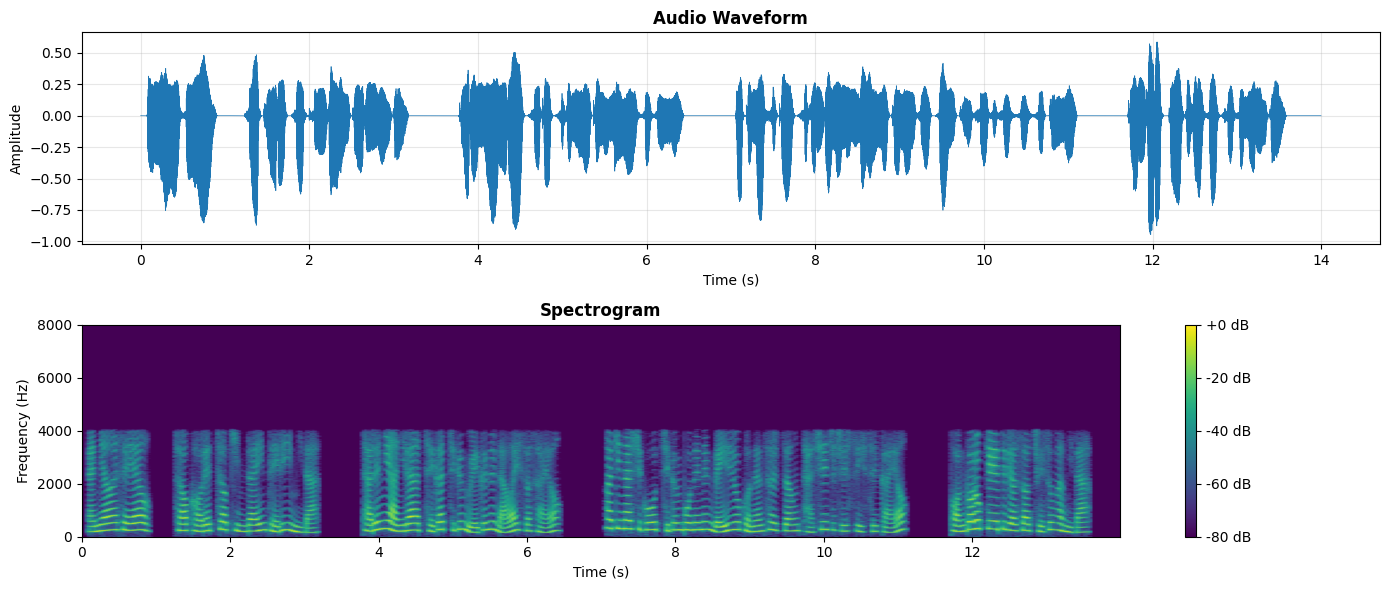


🔄 Feature 추출 중...
🤖 AI 모델 분석 중...

📊 분석 결과
⚠️  판정: FAKE (합성 음성)
   신뢰도: 99.99%

   Real 확률: 0.01%
   Fake 확률: 99.99%



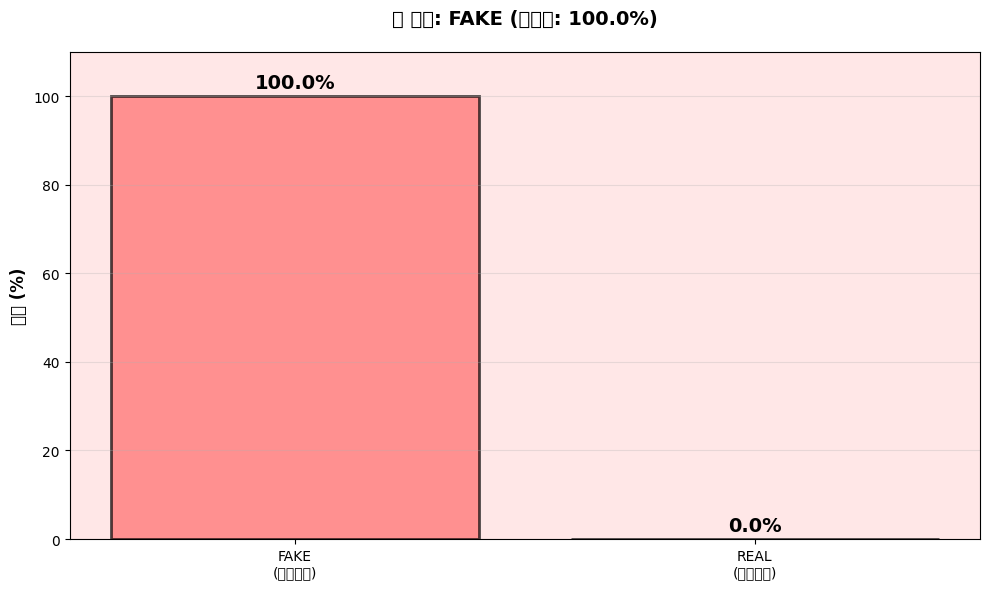


💡 추가 기능: URL에서 오디오 다운로드 후 분석

URL에서 오디오를 다운로드하여 분석하려면:

# 예시
url = "https://example.com/audio.wav"
!wget {url} -O downloaded_audio.wav

result, confidence, probs = predict_deepfake("downloaded_audio.wav")


✅ 모든 설정 완료!

🎯 사용 가능한 기능:

1. 파일 업로드 (위에서 실행됨)
   
2. 개별 파일 분석:
   result, confidence, probs = predict_deepfake("your_audio.wav")

3. 폴더 전체 분석:
   results = analyze_folder("./audio_folder")

4. Google Drive 연동:
   from google.colab import drive
   drive.mount('/content/drive')
   result, confidence, probs = predict_deepfake('/content/drive/MyDrive/audio.wav')



In [ ]:


# ==================== 1. 설치 및 임포트 ====================
print("=" * 60)
print("1. 필수 라이브러리 설치 중...")
print("=" * 60)

!pip install -q transformers torch torchaudio librosa soundfile

import torch
from transformers import Wav2Vec2ForSequenceClassification, Wav2Vec2FeatureExtractor
import librosa
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Audio, display, HTML
import warnings
warnings.filterwarnings('ignore')

print("✅ 라이브러리 설치 완료!")
print(f"PyTorch: {torch.__version__}")
print(f"CUDA 사용 가능: {torch.cuda.is_available()}")

# ==================== 2. 모델 로드 ====================
print("\n" + "=" * 60)
print("2. MelodyMachine 모델 로드 중...")
print("=" * 60)

MODEL_NAME = "MelodyMachine/Deepfake-audio-detection-V2"

print(f"모델: {MODEL_NAME}")
print("다운로드 중... (처음 실행 시 1-2분 소요)")

# Feature extractor와 모델 로드
feature_extractor = Wav2Vec2FeatureExtractor.from_pretrained(MODEL_NAME)
model = Wav2Vec2ForSequenceClassification.from_pretrained(MODEL_NAME)

# GPU 설정
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
model.eval()

print(f"✅ 모델 로드 완료! (Device: {device})")

# ==================== 3. 예측 함수 정의 ====================
def predict_deepfake(audio_path, show_waveform=True):

    print(f"\n{'='*60}")
    print(f"분석 중: {audio_path}")
    print(f"{'='*60}")

    # 1. 오디오 로드 (16kHz로 리샘플링)
    try:
        audio, sr = librosa.load(audio_path, sr=16000)
        duration = len(audio) / sr
        print(f"✅ 오디오 로드 성공")
        print(f"   - 길이: {duration:.2f}초")
        print(f"   - 샘플링 레이트: {sr} Hz")
        print(f"   - 샘플 수: {len(audio):,}")
    except Exception as e:
        print(f"❌ 오디오 로드 실패: {e}")
        return None, None, None

    # 2. 오디오 재생
    print("\n🔊 오디오 재생:")
    display(Audio(audio, rate=sr))

    # 3. 파형 시각화
    if show_waveform:
        fig, axes = plt.subplots(2, 1, figsize=(14, 6))

        # 전체 파형
        axes[0].plot(np.linspace(0, duration, len(audio)), audio, linewidth=0.5)
        axes[0].set_title('Audio Waveform', fontsize=12, fontweight='bold')
        axes[0].set_xlabel('Time (s)')
        axes[0].set_ylabel('Amplitude')
        axes[0].grid(True, alpha=0.3)

        # 스펙트로그램
        D = librosa.amplitude_to_db(np.abs(librosa.stft(audio)), ref=np.max)
        img = axes[1].imshow(D, aspect='auto', origin='lower',
                            extent=[0, duration, 0, sr/2], cmap='viridis')
        axes[1].set_title('Spectrogram', fontsize=12, fontweight='bold')
        axes[1].set_xlabel('Time (s)')
        axes[1].set_ylabel('Frequency (Hz)')
        plt.colorbar(img, ax=axes[1], format='%+2.0f dB')

        plt.tight_layout()
        plt.show()

    # 4. Feature extraction
    print("\n🔄 Feature 추출 중...")
    inputs = feature_extractor(
        audio,
        sampling_rate=16000,
        return_tensors="pt",
        padding=True,
        max_length=16000 * 10,  # 최대 10초
        truncation=True
    )

    input_values = inputs.input_values.to(device)

    # 5. 예측
    print("🤖 AI 모델 분석 중...")
    with torch.no_grad():
        outputs = model(input_values)
        logits = outputs.logits
        probs = torch.nn.functional.softmax(logits, dim=-1)[0]
        predicted_class = torch.argmax(probs).item()
        confidence = probs[predicted_class].item() * 100

    probabilities = probs.cpu().numpy()

    # 결과 (모델에 따라 0/1이 real/fake 순서가 다를 수 있음)
    # MelodyMachine 모델은 0=fake, 1=real로 학습됨
    result = 'REAL' if predicted_class == 1 else 'FAKE'

    # 6. 결과 출력
    print(f"\n{'='*60}")
    print("📊 분석 결과")
    print(f"{'='*60}")

    if result == 'REAL':
        print(f"✅ 판정: {result} (진짜 음성)")
        emoji = "✅"
        color = "green"
    else:
        print(f"⚠️  판정: {result} (합성 음성)")
        emoji = "⚠️"
        color = "red"

    print(f"   신뢰도: {confidence:.2f}%")
    print(f"\n   Real 확률: {probabilities[1]*100:.2f}%")
    print(f"   Fake 확률: {probabilities[0]*100:.2f}%")
    print(f"{'='*60}\n")

    # 7. 결과 시각화
    fig, ax = plt.subplots(figsize=(10, 6))

    labels = ['FAKE\n(합성음성)', 'REAL\n(진짜음성)']
    colors_bar = ['#ff6b6b' if i == 0 else '#51cf66' for i in range(2)]
    bars = ax.bar(labels, probabilities * 100, color=colors_bar, alpha=0.7, edgecolor='black', linewidth=2)

    # 막대 위에 퍼센트 표시
    for i, (bar, prob) in enumerate(zip(bars, probabilities)):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height + 1,
                f'{prob*100:.1f}%',
                ha='center', va='bottom', fontsize=14, fontweight='bold')

    ax.set_ylabel('확률 (%)', fontsize=12, fontweight='bold')
    ax.set_title(f'🎯 판정: {result} (신뢰도: {confidence:.1f}%)',
                 fontsize=14, fontweight='bold', pad=20)
    ax.set_ylim([0, 110])
    ax.grid(axis='y', alpha=0.3)

    # 판정 결과 배경색
    if result == 'REAL':
        ax.set_facecolor('#e7f5e7')
    else:
        ax.set_facecolor('#ffe7e7')

    plt.tight_layout()
    plt.show()

    return result, confidence, probabilities


# ==================== 4. 파일 업로드 및 분석 ====================
print("\n" + "=" * 60)
print("3. 오디오 파일 업로드")
print("=" * 60)

from google.colab import files

print("📁 파일을 선택하여 업로드하세요...")
print("   (지원 형식: .wav, .mp3, .flac, .ogg 등)")
print()

uploaded = files.upload()

if uploaded:
    print(f"\n✅ {len(uploaded)}개 파일 업로드 완료!\n")

    # 업로드된 모든 파일 분석
    results = []

    for filename in uploaded.keys():
        print(f"\n{'#'*60}")
        print(f"파일: {filename}")
        print(f"{'#'*60}")

        result, confidence, probs = predict_deepfake(filename, show_waveform=True)

        if result:
            results.append({
                'filename': filename,
                'result': result,
                'confidence': confidence,
                'real_prob': probs[1] * 100,
                'fake_prob': probs[0] * 100
            })

    # ==================== 5. 종합 결과 ====================
    if len(results) > 1:
        print("\n" + "=" * 60)
        print("📋 종합 결과")
        print("=" * 60)

        for i, res in enumerate(results, 1):
            status_emoji = "✅" if res['result'] == 'REAL' else "⚠️"
            print(f"{i}. {status_emoji} {res['filename']}")
            print(f"   판정: {res['result']} (신뢰도: {res['confidence']:.1f}%)")
            print(f"   Real: {res['real_prob']:.1f}% | Fake: {res['fake_prob']:.1f}%")
            print()

else:
    print("⚠️  업로드된 파일이 없습니다.")

print("\n" + "=" * 60)
print("✅ 모든 설정 완료!")
print("=" * 60)


In [ ]:
#@title ASVspoof 2019 평가 코드 (MelodyMachine 모델)

# ==================== 1. 설치 및 임포트 ====================
print("=" * 60)
print("1. 필수 라이브러리 설치 중...")
print("=" * 60)

!pip install -q transformers torch torchaudio librosa soundfile scikit-learn pandas

import torch
from transformers import Wav2Vec2ForSequenceClassification, Wav2Vec2FeatureExtractor
import librosa
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
from sklearn.metrics import accuracy_score, confusion_matrix
import os
import sys
from google.colab import drive # Google Drive 마운트
import warnings
warnings.filterwarnings('ignore')

print("✅ 라이브러리 설치 완료!")
print(f"PyTorch: {torch.__version__}")
print(f"CUDA 사용 가능: {torch.cuda.is_available()}")

# ==================== 2. Google Drive 마운트 ====================
print("\n" + "=" * 60)
print("2. Google Drive 마운트 중...")
print("=" * 60)
try:
    drive.mount('/content/drive')
    print("✅ Google Drive 마운트 완료!")
except Exception as e:
    print(f"❌ Google Drive 마운트 실패: {e}")

# ==================== 3. 모델 로드 ====================
print("\n" + "=" * 60)
print("3. MelodyMachine 모델 로드 중...")
print("=" * 60)

MODEL_NAME = "MelodyMachine/Deepfake-audio-detection-V2"

print(f"모델: {MODEL_NAME}")
print("다운로드 중... (처음 실행 시 1-2분 소요)")

try:
    # Feature extractor와 모델 로드
    feature_extractor = Wav2Vec2FeatureExtractor.from_pretrained(MODEL_NAME)
    model = Wav2Vec2ForSequenceClassification.from_pretrained(MODEL_NAME)

    # GPU 설정
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)
    model.eval()
    print(f"✅ 모델 로드 완료! (Device: {device})")
except Exception as e:
    print(f"❌ 모델 로드 오류: {e}")
    # 오류 발생 시 스크립트 중단 방지를 위해 더미 변수 할당 (실제 작동 안 함)
    model = None
    feature_extractor = None

# ==================== 4. 경로 설정 및 정답지 로드 ====================
print("\n" + "=" * 60)
print("4. 경로 설정 및 ASVspoof 2019 정답지 로드 중...")
print("=" * 60)

gdrive_base_path = "/content/drive/MyDrive/SeSAC/project/data"
eval_folder_path = os.path.join(gdrive_base_path, "ASVspoof2019_LA_eval")
metadata_path = os.path.join(gdrive_base_path, "ASVspoof2019_LA_cm_protocols/new_answer_sheet.txt")

try:
    metadata_df = pd.read_csv(metadata_path, sep=" ", header=None)
    metadata_df.columns = ["speaker_id", "filename", "dash", "attack_type", "label"]
    answer_key = pd.Series(metadata_df.label.values, index=metadata_df.filename).to_dict()
    print(f"✅ 정답지 로드 완료! 총 {len(answer_key)}개의 평가 데이터")
    print(f"   데이터 폴더: {eval_folder_path}")
except Exception as e:
    print(f"❌ 정답지 로드 오류: {e}")
    answer_key = {} # 오류 시 루프 방지

# ==================== 5. 임계값(Threshold) 설정 ====================
# MelodyMachine 모델은 [0]=fake, [1]=real 이므로, fake 확률은 [0]번 인덱스
# 임계값은 fake 확률에 대해 설정
FAKE_THRESHOLD = 0.1 # 예시 임계값 (0.0 ~ 1.0 사이 값으로 조정 가능)
print(f"\n✅ Fake 임계값 설정: {FAKE_THRESHOLD} (Fake 확률이 이 값 이상이면 FAKE로 판정)")

# ==================== 6. 평가 루프 실행 ====================
if model and feature_extractor and answer_key:
    results_list = []
    print("\n" + "=" * 60)
    print("5. 모델 추론 및 평가 시작...")
    print("=" * 60)

    for filename, true_label_str in tqdm(answer_key.items()):
        file_path = os.path.join(eval_folder_path, f"{filename}.flac")

        try:
            # 1. 오디오 로드 (16kHz)
            audio, sr = librosa.load(file_path, sr=16000)

            # 2. Feature extraction
            inputs = feature_extractor(
                audio,
                sampling_rate=16000,
                return_tensors="pt",
                padding=True,
                max_length=16000 * 10, # 최대 10초 (필요시 조절)
                truncation=True
            )
            input_values = inputs.input_values.to(device)

            # 3. 예측
            with torch.no_grad():
                outputs = model(input_values)
                logits = outputs.logits
                probs = torch.nn.functional.softmax(logits, dim=-1)[0]

                # [0]=fake, [1]=real (MelodyMachine 모델 기준)
                fake_prob = probs[0].item()
                real_prob = probs[1].item()

            # --- 결과 저장 ---
            results_list.append({
                "filename": filename,
                "true_label": true_label_str,
                "fake_probability": fake_prob, # Fake 확률 저장
                "real_probability": real_prob
            })

        except FileNotFoundError:
            continue
        except Exception as e:
            print(f"[❌ 오류] 파일: {filename}.flac | 처리 중 문제 발생: {e}")
            continue

    results_df = pd.DataFrame(results_list)
    print("\n✅ 모델 예측 및 확률 수집 완료!")

    # ==================== 7. 최종 통계 분석 ====================
    print("\n" + "=" * 60)
    print("6. 최종 통계 분석")
    print("=" * 60)

    if not results_df.empty:
        # ASVspoof 기준 라벨(0=bonafide, 1=spoof)로 변환
        label_mapping = {'bonafide': 0, 'spoof': 1}
        results_df['y_true_numeric'] = results_df['true_label'].map(label_mapping)

        # 예측: fake 확률이 임계값을 넘으면 spoof(1), 아니면 bonafide(0)
        results_df['y_pred_numeric'] = (results_df['fake_probability'] >= FAKE_THRESHOLD).astype(int)

        # 예측 레이블 문자열 (확인용)
        results_df['predicted_label'] = results_df['y_pred_numeric'].apply(lambda x: 'spoof' if x == 1 else 'bonafide')

        # 분석 수행
        y_true = results_df['y_true_numeric']
        y_pred = results_df['y_pred_numeric']
        accuracy = accuracy_score(y_true, y_pred)
        cm = confusion_matrix(y_true, y_pred, labels=[0, 1])
        tn, fp, fn, tp = cm.ravel() if cm.size == 4 else (cm[0][0], 0, 0, 0)

        print(f"--- [최종 결과] Threshold = {FAKE_THRESHOLD} (Fake 확률 기준) ---")
        print(f"📊 전체 정확도 (Accuracy): {accuracy:.4%}")
        print("\n📊 혼동 행렬 (Confusion Matrix):")
        print("                  예측: 진짜(BNF)  예측: 가짜(SPF)")
        print(f"실제: 진짜(BNF)    {tn:<10}    {fp:<10}")
        print(f"실제: 가짜(SPF)    {fn:<10}    {tp:<10}")
        print("\n- [FP] 진짜 목소리를 '가짜'라고 잘못 판단한 경우: ", fp, "건")
        print("- [FN] 가짜 목소리를 '진짜'라고 잘못 판단한 경우: ", fn, "건")

        # --- 오답 상세 분석 ---
        error_df = results_df[results_df['y_true_numeric'] != results_df['y_pred_numeric']]
        if not error_df.empty:
            print("\n\n--- ❌ 오답 상세 분석 ---")
            fp_errors = error_df[error_df['y_true_numeric'] == 0]
            if not fp_errors.empty:
                print("\n[진짜(Bonafide) -> 가짜(Spoof)로 잘못 예측]")
                for _, row in fp_errors.iterrows():
                     print(f"  - 파일: {row['filename']} | 예측: {row['predicted_label'].upper()} (Real: {row['real_probability']:.4%}, Fake: {row['fake_probability']:.4%})")
            fn_errors = error_df[error_df['y_true_numeric'] == 1]
            if not fn_errors.empty:
                print("\n[가짜(Spoof) -> 진짜(Bonafide)로 잘못 예측]")
                for _, row in fn_errors.iterrows():
                     print(f"  - 파일: {row['filename']} | 예측: {row['predicted_label'].upper()} (Real: {row['real_probability']:.4%}, Fake: {row['fake_probability']:.4%})")
        else:
            print("\n\n🎉 모든 예측이 정확합니다! 오답이 없습니다.")

    else:
        print("처리된 결과가 없어 통계를 분석할 수 없습니다.")

else:
    print("\n⚠️ 모델 또는 정답지가 제대로 로드되지 않아 평가를 진행할 수 없습니다.")

1. 필수 라이브러리 설치 중...
✅ 라이브러리 설치 완료!
PyTorch: 2.8.0+cu126
CUDA 사용 가능: True

2. Google Drive 마운트 중...
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ Google Drive 마운트 완료!

3. MelodyMachine 모델 로드 중...
모델: MelodyMachine/Deepfake-audio-detection-V2
다운로드 중... (처음 실행 시 1-2분 소요)
✅ 모델 로드 완료! (Device: cuda)

4. 경로 설정 및 ASVspoof 2019 정답지 로드 중...
✅ 정답지 로드 완료! 총 2028개의 평가 데이터
   데이터 폴더: /content/drive/MyDrive/SeSAC/project/data/ASVspoof2019_LA_eval

✅ Fake 임계값 설정: 0.1 (Fake 확률이 이 값 이상이면 FAKE로 판정)

5. 모델 추론 및 평가 시작...


  0%|          | 0/2028 [00:00<?, ?it/s]


✅ 모델 예측 및 확률 수집 완료!

6. 최종 통계 분석
--- [최종 결과] Threshold = 0.1 (Fake 확률 기준) ---
📊 전체 정확도 (Accuracy): 47.6824%

📊 혼동 행렬 (Confusion Matrix):
                  예측: 진짜(BNF)  예측: 가짜(SPF)
실제: 진짜(BNF)    200           0         
실제: 가짜(SPF)    1061          767       

- [FP] 진짜 목소리를 '가짜'라고 잘못 판단한 경우:  0 건
- [FN] 가짜 목소리를 '진짜'라고 잘못 판단한 경우:  1061 건


--- ❌ 오답 상세 분석 ---

[가짜(Spoof) -> 진짜(Bonafide)로 잘못 예측]
  - 파일: LA_E_1070406 | 예측: BONAFIDE (Real: 99.9983%, Fake: 0.0017%)
  - 파일: LA_E_9723884 | 예측: BONAFIDE (Real: 99.9178%, Fake: 0.0822%)
  - 파일: LA_E_9755088 | 예측: BONAFIDE (Real: 99.9983%, Fake: 0.0017%)
  - 파일: LA_E_9672753 | 예측: BONAFIDE (Real: 99.9983%, Fake: 0.0017%)
  - 파일: LA_E_9635335 | 예측: BONAFIDE (Real: 99.9983%, Fake: 0.0017%)
  - 파일: LA_E_9716942 | 예측: BONAFIDE (Real: 99.9983%, Fake: 0.0017%)
  - 파일: LA_E_9695591 | 예측: BONAFIDE (Real: 99.9053%, Fake: 0.0947%)
  - 파일: LA_E_1031731 | 예측: BONAFIDE (Real: 99.9983%, Fake: 0.0017%)
  - 파일: LA_E_1082906 | 예측: BONAFIDE (Real: 99.9982%, Fake:

1. 필수 라이브러리 설치 중...
✅ 라이브러리 설치 완료!
PyTorch: 2.8.0+cu126
CUDA 사용 가능: True

2. Google Drive 마운트 중...
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ Google Drive 마운트 완료!

3. MelodyMachine 모델 로드 중...
모델: MelodyMachine/Deepfake-audio-detection-V2
다운로드 중... (처음 실행 시 1-2분 소요)
✅ 모델 로드 완료! (Device: cuda)

4. 경로 설정 및 ASVspoof 2019 정답지 로드 중...
✅ 정답지 로드 완료! 총 2028개의 평가 데이터
   - Bonafide (진짜): 200개
   - Spoof (가짜): 1828개
   데이터 폴더: /content/drive/MyDrive/SeSAC/project/data/ASVspoof2019_LA_eval

5. 모델 추론 시작... (확률 수집)


추론 중:   0%|          | 0/2028 [00:00<?, ?it/s]


✅ 총 2028개 파일 예측 완료!

6. 확률 분포 분석

📊 Fake 확률 분포 통계:
  Bonafide (진짜) - 평균: 0.0000, 중간값: 0.0000
  Spoof (가짜)    - 평균: 0.4185, 중간값: 0.0001


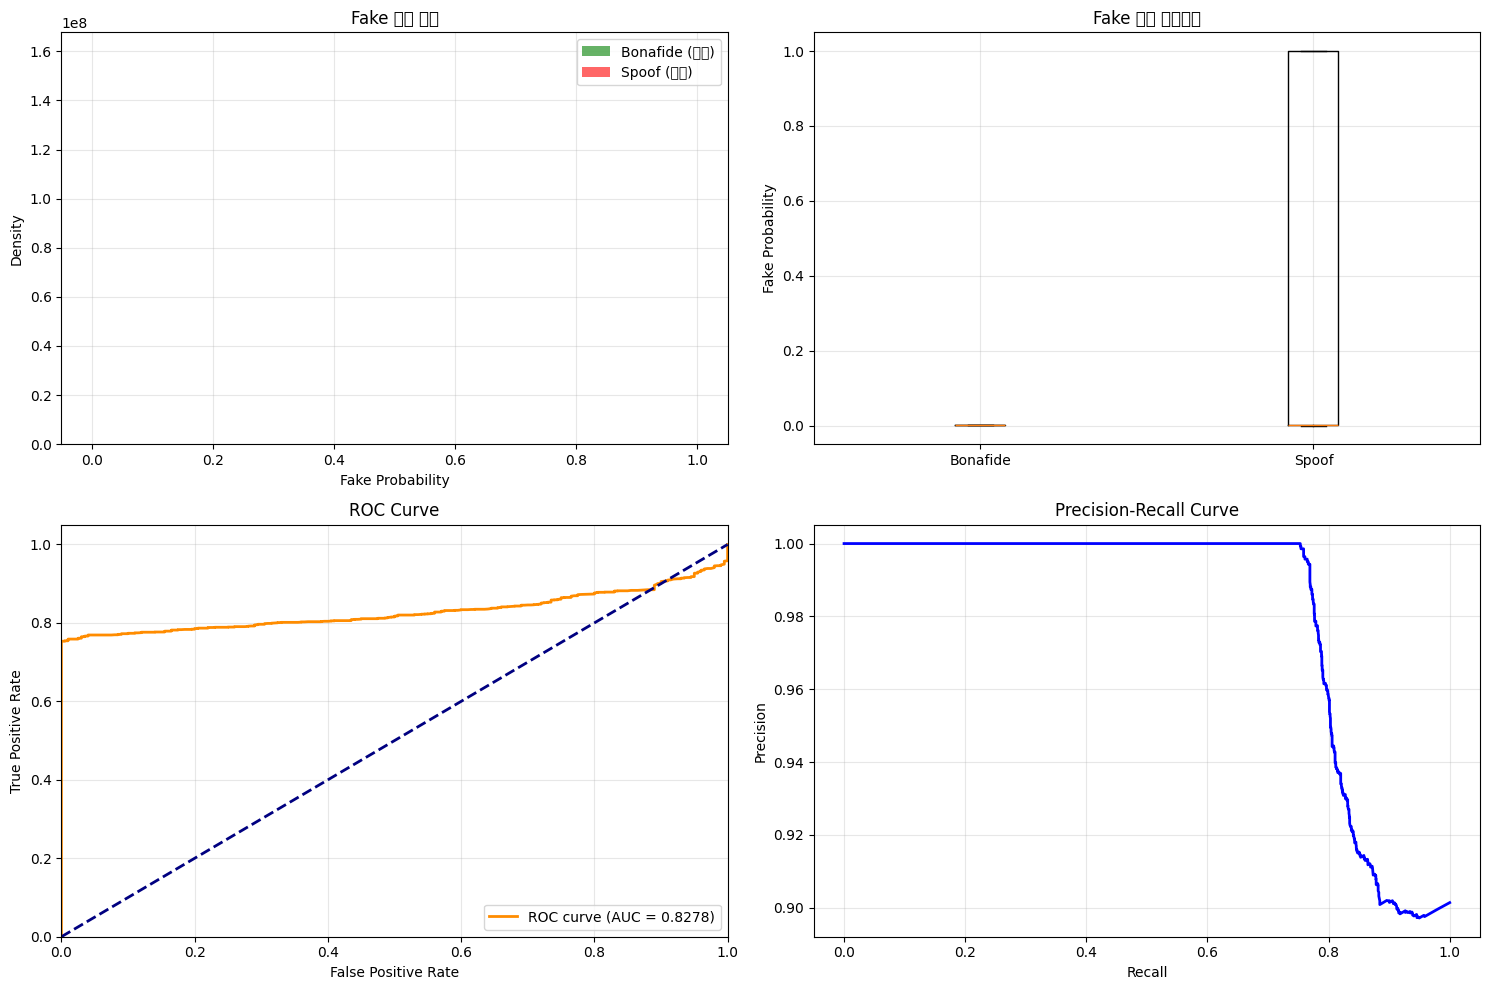


7. 최적 임계값 탐색

🎯 최적 임계값 후보:

1. 최고 정확도 (Accuracy):
   Threshold: 0.10
   Accuracy: 47.6824%
   F1 Score: 0.5911

2. 최고 F1 Score:
   Threshold: 0.10
   Accuracy: 47.6824%
   F1 Score: 0.5911

3. 최소 EER (Equal Error Rate):
   Threshold: 0.10
   Accuracy: 47.6824%
   F1 Score: 0.5911


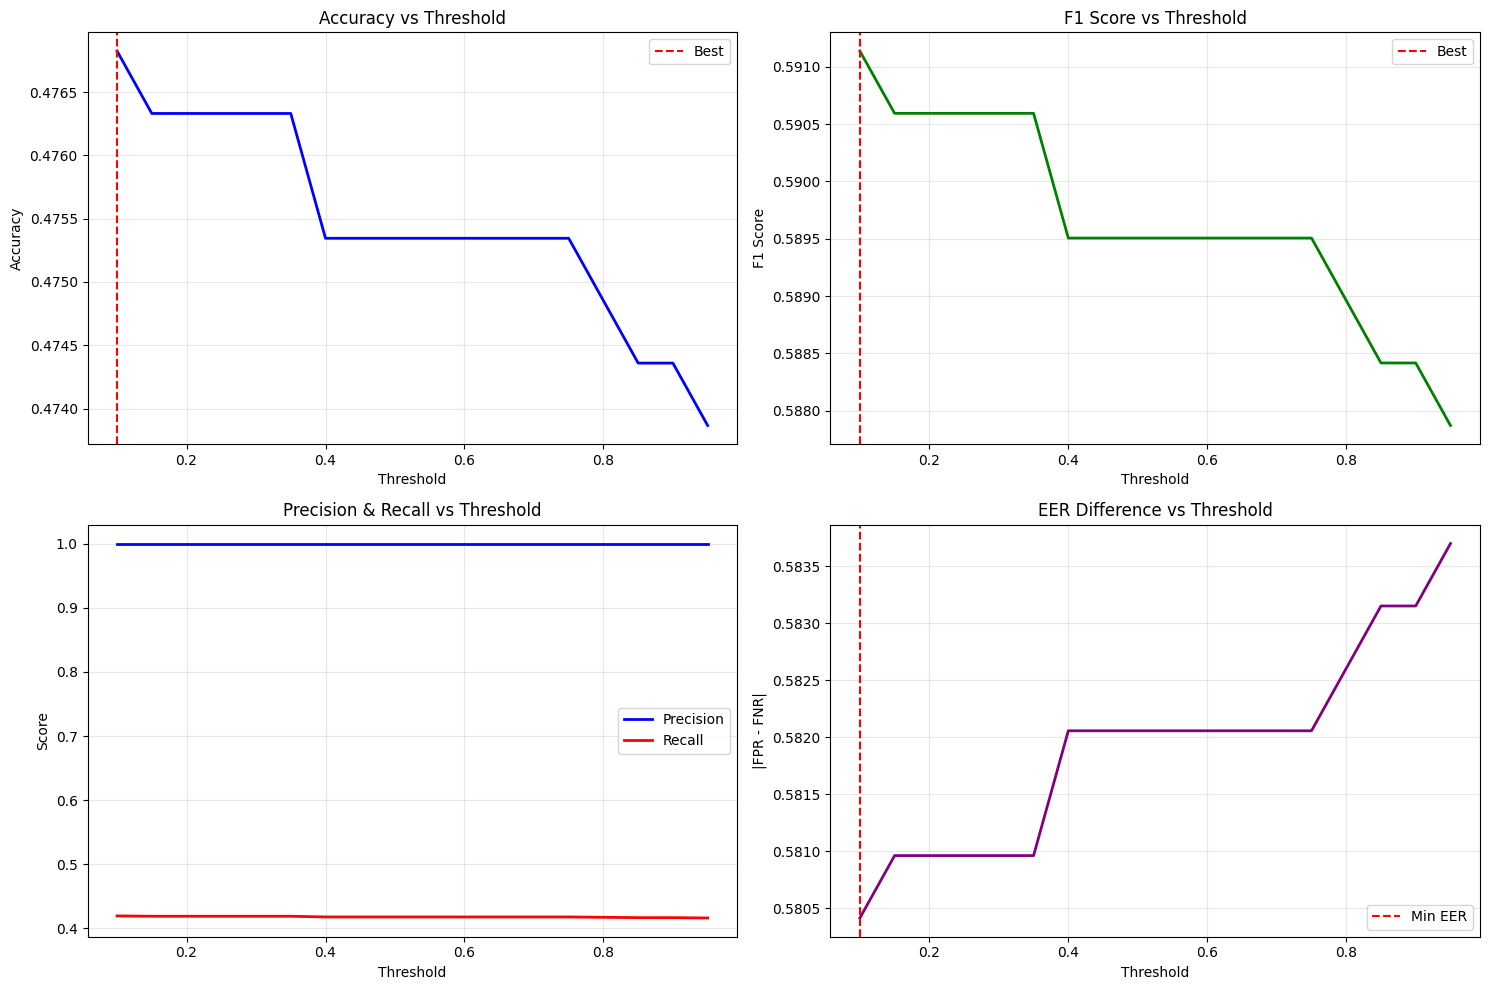


8. 최적 임계값으로 최종 평가

✅ 최적 임계값: 0.10

📊 전체 정확도 (Accuracy): 47.6824%

📊 혼동 행렬 (Confusion Matrix):
                  예측: 진짜(BNF)  예측: 가짜(SPF)
실제: 진짜(BNF)    200           0         
실제: 가짜(SPF)    1061          767       

- True Positive (TP):  767 - 가짜를 가짜로 올바르게 판정
- True Negative (TN):  200 - 진짜를 진짜로 올바르게 판정
- False Positive (FP):    0 - 진짜를 가짜로 잘못 판정
- False Negative (FN): 1061 - 가짜를 진짜로 잘못 판정

📊 상세 분류 리포트:
              precision    recall  f1-score   support

    Bonafide     0.1586    1.0000    0.2738       200
       Spoof     1.0000    0.4196    0.5911      1828

    accuracy                         0.4768      2028
   macro avg     0.5793    0.7098    0.4325      2028
weighted avg     0.9170    0.4768    0.5598      2028



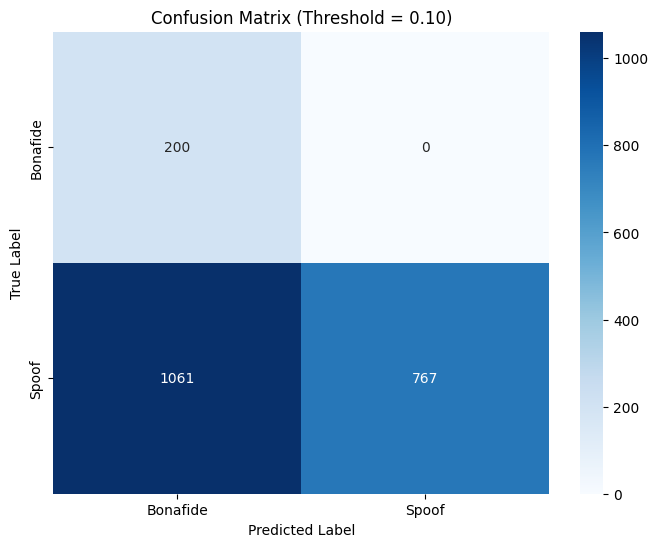



9. 오답 분석 (총 1061건)

[False Negative: 가짜 → 진짜로 오판] (1061건)
상위 10개 (Fake 확률이 낮은 순):
  1. LA_E_9738732 | Fake확률: 0.0000
  2. LA_E_1006563 | Fake확률: 0.0000
  3. LA_E_1007838 | Fake확률: 0.0000
  4. LA_E_1085979 | Fake확률: 0.0000
  5. LA_E_1027275 | Fake확률: 0.0000
  6. LA_E_9746649 | Fake확률: 0.0000
  7. LA_E_9674428 | Fake확률: 0.0000
  8. LA_E_9751325 | Fake확률: 0.0000
  9. LA_E_1022330 | Fake확률: 0.0000
  10. LA_E_9722569 | Fake확률: 0.0000

💾 결과 저장 완료:
  - asvspoof_evaluation_results.csv
  - threshold_analysis.csv


In [ ]:
#@title ASVspoof 2019 평가 코드 (최적 임계값 탐색)

# ==================== 1. 설치 및 임포트 ====================
print("=" * 60)
print("1. 필수 라이브러리 설치 중...")
print("=" * 60)

!pip install -q transformers torch torchaudio librosa soundfile scikit-learn pandas matplotlib seaborn

import torch
from transformers import Wav2Vec2ForSequenceClassification, Wav2Vec2FeatureExtractor
import librosa
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
from sklearn.metrics import (
    accuracy_score, confusion_matrix, classification_report,
    roc_curve, auc, precision_recall_curve
)
import matplotlib.pyplot as plt
import seaborn as sns
import os
from google.colab import drive
import warnings
warnings.filterwarnings('ignore')

print("✅ 라이브러리 설치 완료!")
print(f"PyTorch: {torch.__version__}")
print(f"CUDA 사용 가능: {torch.cuda.is_available()}")

# ==================== 2. Google Drive 마운트 ====================
print("\n" + "=" * 60)
print("2. Google Drive 마운트 중...")
print("=" * 60)
try:
    drive.mount('/content/drive')
    print("✅ Google Drive 마운트 완료!")
except Exception as e:
    print(f"❌ Google Drive 마운트 실패: {e}")

# ==================== 3. 모델 로드 ====================
print("\n" + "=" * 60)
print("3. MelodyMachine 모델 로드 중...")
print("=" * 60)

MODEL_NAME = "MelodyMachine/Deepfake-audio-detection-V2"

print(f"모델: {MODEL_NAME}")
print("다운로드 중... (처음 실행 시 1-2분 소요)")

try:
    feature_extractor = Wav2Vec2FeatureExtractor.from_pretrained(MODEL_NAME)
    model = Wav2Vec2ForSequenceClassification.from_pretrained(MODEL_NAME)

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)
    model.eval()
    print(f"✅ 모델 로드 완료! (Device: {device})")
except Exception as e:
    print(f"❌ 모델 로드 오류: {e}")
    model = None
    feature_extractor = None

# ==================== 4. 경로 설정 및 정답지 로드 ====================
print("\n" + "=" * 60)
print("4. 경로 설정 및 ASVspoof 2019 정답지 로드 중...")
print("=" * 60)

gdrive_base_path = "/content/drive/MyDrive/SeSAC/project/data"
eval_folder_path = os.path.join(gdrive_base_path, "ASVspoof2019_LA_eval")
metadata_path = os.path.join(gdrive_base_path, "ASVspoof2019_LA_cm_protocols/new_answer_sheet.txt")

try:
    metadata_df = pd.read_csv(metadata_path, sep=" ", header=None)
    metadata_df.columns = ["speaker_id", "filename", "dash", "attack_type", "label"]
    answer_key = pd.Series(metadata_df.label.values, index=metadata_df.filename).to_dict()
    print(f"✅ 정답지 로드 완료! 총 {len(answer_key)}개의 평가 데이터")
    print(f"   - Bonafide (진짜): {sum(1 for v in answer_key.values() if v == 'bonafide')}개")
    print(f"   - Spoof (가짜): {sum(1 for v in answer_key.values() if v == 'spoof')}개")
    print(f"   데이터 폴더: {eval_folder_path}")
except Exception as e:
    print(f"❌ 정답지 로드 오류: {e}")
    answer_key = {}

# ==================== 5. 평가 루프 실행 (확률 수집) ====================
if model and feature_extractor and answer_key:
    results_list = []
    print("\n" + "=" * 60)
    print("5. 모델 추론 시작... (확률 수집)")
    print("=" * 60)

    for filename, true_label_str in tqdm(answer_key.items(), desc="추론 중"):
        file_path = os.path.join(eval_folder_path, f"{filename}.flac")

        try:
            # 오디오 로드
            audio, sr = librosa.load(file_path, sr=16000)

            # Feature extraction
            inputs = feature_extractor(
                audio,
                sampling_rate=16000,
                return_tensors="pt",
                padding=True,
                max_length=16000 * 10,
                truncation=True
            )
            input_values = inputs.input_values.to(device)

            # 예측
            with torch.no_grad():
                outputs = model(input_values)
                logits = outputs.logits
                probs = torch.nn.functional.softmax(logits, dim=-1)[0]

                # [0]=fake, [1]=real (MelodyMachine 모델 기준)
                fake_prob = probs[0].item()
                real_prob = probs[1].item()

            results_list.append({
                "filename": filename,
                "true_label": true_label_str,
                "fake_probability": fake_prob,
                "real_probability": real_prob
            })

        except FileNotFoundError:
            continue
        except Exception as e:
            continue

    results_df = pd.DataFrame(results_list)
    print(f"\n✅ 총 {len(results_df)}개 파일 예측 완료!")

    # ==================== 6. 확률 분포 분석 ====================
    print("\n" + "=" * 60)
    print("6. 확률 분포 분석")
    print("=" * 60)

    if not results_df.empty:
        # 라벨별 통계
        label_mapping = {'bonafide': 0, 'spoof': 1}
        results_df['y_true_numeric'] = results_df['true_label'].map(label_mapping)

        bonafide_df = results_df[results_df['true_label'] == 'bonafide']
        spoof_df = results_df[results_df['true_label'] == 'spoof']

        print("\n📊 Fake 확률 분포 통계:")
        print(f"  Bonafide (진짜) - 평균: {bonafide_df['fake_probability'].mean():.4f}, "
              f"중간값: {bonafide_df['fake_probability'].median():.4f}")
        print(f"  Spoof (가짜)    - 평균: {spoof_df['fake_probability'].mean():.4f}, "
              f"중간값: {spoof_df['fake_probability'].median():.4f}")

        # 시각화
        fig, axes = plt.subplots(2, 2, figsize=(15, 10))

        # 1. Fake 확률 분포 (히스토그램)
        axes[0, 0].hist(bonafide_df['fake_probability'], bins=50, alpha=0.6,
                        label='Bonafide (진짜)', color='green', density=True)
        axes[0, 0].hist(spoof_df['fake_probability'], bins=50, alpha=0.6,
                        label='Spoof (가짜)', color='red', density=True)
        axes[0, 0].set_xlabel('Fake Probability')
        axes[0, 0].set_ylabel('Density')
        axes[0, 0].set_title('Fake 확률 분포')
        axes[0, 0].legend()
        axes[0, 0].grid(alpha=0.3)

        # 2. 박스플롯
        data_for_box = [bonafide_df['fake_probability'], spoof_df['fake_probability']]
        axes[0, 1].boxplot(data_for_box, labels=['Bonafide', 'Spoof'])
        axes[0, 1].set_ylabel('Fake Probability')
        axes[0, 1].set_title('Fake 확률 박스플롯')
        axes[0, 1].grid(alpha=0.3)

        # 3. ROC Curve
        fpr, tpr, thresholds = roc_curve(results_df['y_true_numeric'],
                                          results_df['fake_probability'])
        roc_auc = auc(fpr, tpr)

        axes[1, 0].plot(fpr, tpr, color='darkorange', lw=2,
                        label=f'ROC curve (AUC = {roc_auc:.4f})')
        axes[1, 0].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        axes[1, 0].set_xlim([0.0, 1.0])
        axes[1, 0].set_ylim([0.0, 1.05])
        axes[1, 0].set_xlabel('False Positive Rate')
        axes[1, 0].set_ylabel('True Positive Rate')
        axes[1, 0].set_title('ROC Curve')
        axes[1, 0].legend(loc="lower right")
        axes[1, 0].grid(alpha=0.3)

        # 4. Precision-Recall Curve
        precision, recall, pr_thresholds = precision_recall_curve(
            results_df['y_true_numeric'], results_df['fake_probability']
        )

        axes[1, 1].plot(recall, precision, color='blue', lw=2)
        axes[1, 1].set_xlabel('Recall')
        axes[1, 1].set_ylabel('Precision')
        axes[1, 1].set_title('Precision-Recall Curve')
        axes[1, 1].grid(alpha=0.3)

        plt.tight_layout()
        plt.show()

        # ==================== 7. 최적 임계값 탐색 ====================
        print("\n" + "=" * 60)
        print("7. 최적 임계값 탐색")
        print("=" * 60)

        # 여러 임계값에 대해 성능 측정
        thresholds_to_test = np.arange(0.1, 1.0, 0.05)
        threshold_results = []

        for thresh in thresholds_to_test:
            y_pred = (results_df['fake_probability'] >= thresh).astype(int)
            y_true = results_df['y_true_numeric']

            acc = accuracy_score(y_true, y_pred)
            cm = confusion_matrix(y_true, y_pred, labels=[0, 1])

            if cm.size == 4:
                tn, fp, fn, tp = cm.ravel()

                # 메트릭 계산
                precision = tp / (tp + fp) if (tp + fp) > 0 else 0
                recall = tp / (tp + fn) if (tp + fn) > 0 else 0
                f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

                # EER 근사 (FPR과 FNR의 차이가 최소인 지점)
                fpr = fp / (fp + tn) if (fp + tn) > 0 else 0
                fnr = fn / (fn + tp) if (fn + tp) > 0 else 0
                eer_diff = abs(fpr - fnr)

                threshold_results.append({
                    'threshold': thresh,
                    'accuracy': acc,
                    'precision': precision,
                    'recall': recall,
                    'f1': f1,
                    'eer_diff': eer_diff,
                    'tp': tp, 'fp': fp, 'tn': tn, 'fn': fn
                })

        threshold_df = pd.DataFrame(threshold_results)

        # 최적 임계값들
        best_acc_idx = threshold_df['accuracy'].idxmax()
        best_f1_idx = threshold_df['f1'].idxmax()
        best_eer_idx = threshold_df['eer_diff'].idxmin()

        print("\n🎯 최적 임계값 후보:")
        print(f"\n1. 최고 정확도 (Accuracy):")
        print(f"   Threshold: {threshold_df.loc[best_acc_idx, 'threshold']:.2f}")
        print(f"   Accuracy: {threshold_df.loc[best_acc_idx, 'accuracy']:.4%}")
        print(f"   F1 Score: {threshold_df.loc[best_acc_idx, 'f1']:.4f}")

        print(f"\n2. 최고 F1 Score:")
        print(f"   Threshold: {threshold_df.loc[best_f1_idx, 'threshold']:.2f}")
        print(f"   Accuracy: {threshold_df.loc[best_f1_idx, 'accuracy']:.4%}")
        print(f"   F1 Score: {threshold_df.loc[best_f1_idx, 'f1']:.4f}")

        print(f"\n3. 최소 EER (Equal Error Rate):")
        print(f"   Threshold: {threshold_df.loc[best_eer_idx, 'threshold']:.2f}")
        print(f"   Accuracy: {threshold_df.loc[best_eer_idx, 'accuracy']:.4%}")
        print(f"   F1 Score: {threshold_df.loc[best_eer_idx, 'f1']:.4f}")

        # 임계값별 성능 시각화
        fig, axes = plt.subplots(2, 2, figsize=(15, 10))

        axes[0, 0].plot(threshold_df['threshold'], threshold_df['accuracy'], 'b-', lw=2)
        axes[0, 0].axvline(threshold_df.loc[best_acc_idx, 'threshold'],
                          color='r', linestyle='--', label='Best')
        axes[0, 0].set_xlabel('Threshold')
        axes[0, 0].set_ylabel('Accuracy')
        axes[0, 0].set_title('Accuracy vs Threshold')
        axes[0, 0].legend()
        axes[0, 0].grid(alpha=0.3)

        axes[0, 1].plot(threshold_df['threshold'], threshold_df['f1'], 'g-', lw=2)
        axes[0, 1].axvline(threshold_df.loc[best_f1_idx, 'threshold'],
                          color='r', linestyle='--', label='Best')
        axes[0, 1].set_xlabel('Threshold')
        axes[0, 1].set_ylabel('F1 Score')
        axes[0, 1].set_title('F1 Score vs Threshold')
        axes[0, 1].legend()
        axes[0, 1].grid(alpha=0.3)

        axes[1, 0].plot(threshold_df['threshold'], threshold_df['precision'],
                       'b-', lw=2, label='Precision')
        axes[1, 0].plot(threshold_df['threshold'], threshold_df['recall'],
                       'r-', lw=2, label='Recall')
        axes[1, 0].set_xlabel('Threshold')
        axes[1, 0].set_ylabel('Score')
        axes[1, 0].set_title('Precision & Recall vs Threshold')
        axes[1, 0].legend()
        axes[1, 0].grid(alpha=0.3)

        axes[1, 1].plot(threshold_df['threshold'], threshold_df['eer_diff'], 'purple', lw=2)
        axes[1, 1].axvline(threshold_df.loc[best_eer_idx, 'threshold'],
                          color='r', linestyle='--', label='Min EER')
        axes[1, 1].set_xlabel('Threshold')
        axes[1, 1].set_ylabel('|FPR - FNR|')
        axes[1, 1].set_title('EER Difference vs Threshold')
        axes[1, 1].legend()
        axes[1, 1].grid(alpha=0.3)

        plt.tight_layout()
        plt.show()

        # ==================== 8. 최적 임계값으로 최종 평가 ====================
        print("\n" + "=" * 60)
        print("8. 최적 임계값으로 최종 평가")
        print("=" * 60)

        # F1 Score가 가장 높은 임계값 사용 (권장)
        OPTIMAL_THRESHOLD = threshold_df.loc[best_f1_idx, 'threshold']

        y_pred = (results_df['fake_probability'] >= OPTIMAL_THRESHOLD).astype(int)
        y_true = results_df['y_true_numeric']

        results_df['predicted_label'] = y_pred.apply(lambda x: 'spoof' if x == 1 else 'bonafide')

        accuracy = accuracy_score(y_true, y_pred)
        cm = confusion_matrix(y_true, y_pred, labels=[0, 1])

        print(f"\n✅ 최적 임계값: {OPTIMAL_THRESHOLD:.2f}")
        print(f"\n📊 전체 정확도 (Accuracy): {accuracy:.4%}")
        print(f"\n📊 혼동 행렬 (Confusion Matrix):")

        if cm.size == 4:
            tn, fp, fn, tp = cm.ravel()
            print("                  예측: 진짜(BNF)  예측: 가짜(SPF)")
            print(f"실제: 진짜(BNF)    {tn:<10}    {fp:<10}")
            print(f"실제: 가짜(SPF)    {fn:<10}    {tp:<10}")
            print(f"\n- True Positive (TP): {tp:4d} - 가짜를 가짜로 올바르게 판정")
            print(f"- True Negative (TN): {tn:4d} - 진짜를 진짜로 올바르게 판정")
            print(f"- False Positive (FP): {fp:4d} - 진짜를 가짜로 잘못 판정")
            print(f"- False Negative (FN): {fn:4d} - 가짜를 진짜로 잘못 판정")

            # Classification Report
            print("\n📊 상세 분류 리포트:")
            print(classification_report(y_true, y_pred,
                                       target_names=['Bonafide', 'Spoof'],
                                       digits=4))

            # Confusion Matrix 시각화
            plt.figure(figsize=(8, 6))
            sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                       xticklabels=['Bonafide', 'Spoof'],
                       yticklabels=['Bonafide', 'Spoof'])
            plt.title(f'Confusion Matrix (Threshold = {OPTIMAL_THRESHOLD:.2f})')
            plt.ylabel('True Label')
            plt.xlabel('Predicted Label')
            plt.show()

        # ==================== 9. 오답 분석 ====================
        error_df = results_df[results_df['y_true_numeric'] != y_pred]

        if not error_df.empty:
            print(f"\n\n{'='*60}")
            print(f"9. 오답 분석 (총 {len(error_df)}건)")
            print(f"{'='*60}")

            fp_errors = error_df[error_df['y_true_numeric'] == 0]
            fn_errors = error_df[error_df['y_true_numeric'] == 1]

            if not fp_errors.empty:
                print(f"\n[False Positive: 진짜 → 가짜로 오판] ({len(fp_errors)}건)")
                print("상위 10개:")
                for idx, (_, row) in enumerate(fp_errors.nlargest(10, 'fake_probability').iterrows(), 1):
                    print(f"  {idx}. {row['filename']} | Fake확률: {row['fake_probability']:.4f}")

            if not fn_errors.empty:
                print(f"\n[False Negative: 가짜 → 진짜로 오판] ({len(fn_errors)}건)")
                print("상위 10개 (Fake 확률이 낮은 순):")
                for idx, (_, row) in enumerate(fn_errors.nsmallest(10, 'fake_probability').iterrows(), 1):
                    print(f"  {idx}. {row['filename']} | Fake확률: {row['fake_probability']:.4f}")

        # 결과 저장
        results_df.to_csv('asvspoof_evaluation_results.csv', index=False)
        threshold_df.to_csv('threshold_analysis.csv', index=False)
        print(f"\n💾 결과 저장 완료:")
        print(f"  - asvspoof_evaluation_results.csv")
        print(f"  - threshold_analysis.csv")

    else:
        print("처리된 결과가 없어 통계를 분석할 수 없습니다.")

else:
    print("\n⚠️ 모델 또는 정답지가 제대로 로드되지 않아 평가를 진행할 수 없습니다.")

In [ ]:
#@title 🔍 레이블 방향 확인 및 수정 코드

# ==================== 1. 레이블 확인 테스트 ====================
print("=" * 60)
print("1. 모델 레이블 방향 확인")
print("=" * 60)

import torch
from transformers import Wav2Vec2ForSequenceClassification, Wav2Vec2FeatureExtractor
import librosa
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import os
from google.colab import drive

# 드라이브 마운트
try:
    drive.mount('/content/drive')
except:
    pass

# 모델 로드
MODEL_NAME = "MelodyMachine/Deepfake-audio-detection-V2"
feature_extractor = Wav2Vec2FeatureExtractor.from_pretrained(MODEL_NAME)
model = Wav2Vec2ForSequenceClassification.from_pretrained(MODEL_NAME)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
model.eval()

print(f"✅ 모델 로드 완료! (Device: {device})")
print(f"📊 모델 config:")
print(f"   - num_labels: {model.config.num_labels}")
print(f"   - id2label: {model.config.id2label if hasattr(model.config, 'id2label') else 'Not specified'}")
print(f"   - label2id: {model.config.label2id if hasattr(model.config, 'label2id') else 'Not specified'}")

# ==================== 2. 샘플 데이터로 레이블 방향 확인 ====================
print("\n" + "=" * 60)
print("2. 실제 데이터로 레이블 방향 확인")
print("=" * 60)

gdrive_base_path = "/content/drive/MyDrive/SeSAC/project/data"
eval_folder_path = os.path.join(gdrive_base_path, "ASVspoof2019_LA_eval")
metadata_path = os.path.join(gdrive_base_path, "ASVspoof2019_LA_cm_protocols/new_answer_sheet.txt")

metadata_df = pd.read_csv(metadata_path, sep=" ", header=None)
metadata_df.columns = ["speaker_id", "filename", "dash", "attack_type", "label"]

# Bonafide와 Spoof 샘플 각각 5개씩 테스트
bonafide_samples = metadata_df[metadata_df['label'] == 'bonafide']['filename'].head(50).tolist()
spoof_samples = metadata_df[metadata_df['label'] == 'spoof']['filename'].head(50).tolist()

print("🔍 Bonafide (진짜 음성) 샘플 5개 테스트:")
bonafide_probs = []
for filename in bonafide_samples:
    file_path = os.path.join(eval_folder_path, f"{filename}.flac")
    try:
        audio, sr = librosa.load(file_path, sr=16000)
        inputs = feature_extractor(audio, sampling_rate=16000, return_tensors="pt", padding=True)
        input_values = inputs.input_values.to(device)

        with torch.no_grad():
            outputs = model(input_values)
            logits = outputs.logits
            probs = torch.nn.functional.softmax(logits, dim=-1)[0]
            prob_0 = probs[0].item()
            prob_1 = probs[1].item()

        bonafide_probs.append([prob_0, prob_1])
        print(f"  {filename}: [0]={prob_0:.4f}, [1]={prob_1:.4f}")
    except Exception as e:
        print(f"  {filename}: 오류 - {e}")

print("\n🔍 Spoof (합성 음성) 샘플 5개 테스트:")
spoof_probs = []
for filename in spoof_samples:
    file_path = os.path.join(eval_folder_path, f"{filename}.flac")
    try:
        audio, sr = librosa.load(file_path, sr=16000)
        inputs = feature_extractor(audio, sampling_rate=16000, return_tensors="pt", padding=True)
        input_values = inputs.input_values.to(device)

        with torch.no_grad():
            outputs = model(input_values)
            logits = outputs.logits
            probs = torch.nn.functional.softmax(logits, dim=-1)[0]
            prob_0 = probs[0].item()
            prob_1 = probs[1].item()

        spoof_probs.append([prob_0, prob_1])
        print(f"  {filename}: [0]={prob_0:.4f}, [1]={prob_1:.4f}")
    except Exception as e:
        print(f"  {filename}: 오류 - {e}")

# ==================== 3. 레이블 방향 판단 ====================
print("\n" + "=" * 60)
print("3. 레이블 방향 분석")
print("=" * 60)

bonafide_probs = np.array(bonafide_probs)
spoof_probs = np.array(spoof_probs)

bonafide_avg_0 = bonafide_probs[:, 0].mean()
bonafide_avg_1 = bonafide_probs[:, 1].mean()
spoof_avg_0 = spoof_probs[:, 0].mean()
spoof_avg_1 = spoof_probs[:, 1].mean()

print(f"📊 평균 확률:")
print(f"  Bonafide (진짜): [0]={bonafide_avg_0:.4f}, [1]={bonafide_avg_1:.4f}")
print(f"  Spoof (가짜):    [0]={spoof_avg_0:.4f}, [1]={spoof_avg_1:.4f}")

print("\n🎯 레이블 방향 판단:")

# 케이스 1: [0]=bonafide(real), [1]=spoof(fake)
if bonafide_avg_0 > bonafide_avg_1 and spoof_avg_1 > spoof_avg_0:
    label_mapping = "정상"
    print("  ✅ [0] = REAL (Bonafide)")
    print("  ✅ [1] = FAKE (Spoof)")
    USE_REVERSED = False
# 케이스 2: [0]=spoof(fake), [1]=bonafide(real) - 반대!
elif bonafide_avg_1 > bonafide_avg_0 and spoof_avg_0 > spoof_avg_1:
    label_mapping = "반대"
    print("  ⚠️  [0] = FAKE (Spoof)")
    print("  ⚠️  [1] = REAL (Bonafide)")
    print("  ⚠️  레이블이 반대로 되어 있습니다!")
    USE_REVERSED = True
else:
    label_mapping = "불명확"
    print("  ❓ 레이블 방향을 명확히 판단할 수 없습니다.")
    print("  더 많은 샘플로 테스트가 필요합니다.")
    USE_REVERSED = False

# ==================== 4. 전체 데이터셋 재평가 (올바른 레이블 사용) ====================
print("\n" + "=" * 60)
print("4. 올바른 레이블로 전체 데이터셋 재평가")
print("=" * 60)

answer_key = pd.Series(metadata_df.label.values, index=metadata_df.filename).to_dict()
results_list = []

print(f"레이블 설정: {'반대로 해석' if USE_REVERSED else '정상'}")
print("추론 시작...")

for filename, true_label_str in tqdm(list(answer_key.items())[:100], desc="테스트 (100개)"):  # 일단 100개만
    file_path = os.path.join(eval_folder_path, f"{filename}.flac")

    try:
        audio, sr = librosa.load(file_path, sr=16000)
        inputs = feature_extractor(audio, sampling_rate=16000, return_tensors="pt",
                                   padding=True, max_length=16000*10, truncation=True)
        input_values = inputs.input_values.to(device)

        with torch.no_grad():
            outputs = model(input_values)
            logits = outputs.logits
            probs = torch.nn.functional.softmax(logits, dim=-1)[0]

            if USE_REVERSED:
                # 레이블이 반대: [0]=fake, [1]=real
                fake_prob = probs[0].item()
                real_prob = probs[1].item()
            else:
                # 정상: [0]=real, [1]=fake
                real_prob = probs[0].item()
                fake_prob = probs[1].item()

        results_list.append({
            "filename": filename,
            "true_label": true_label_str,
            "fake_probability": fake_prob,
            "real_probability": real_prob
        })

    except Exception as e:
        continue

results_df = pd.DataFrame(results_list)

# ==================== 5. 임계값 탐색 및 평가 ====================
print("\n" + "=" * 60)
print("5. 임계값 탐색")
print("=" * 60)

label_mapping = {'bonafide': 0, 'spoof': 1}
results_df['y_true_numeric'] = results_df['true_label'].map(label_mapping)

thresholds_to_test = [0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
best_acc = 0
best_thresh = 0.5

print(f"\n{'Threshold':<12} {'Accuracy':<12} {'Precision':<12} {'Recall':<12} {'F1':<12}")
print("=" * 60)

for thresh in thresholds_to_test:
    y_pred = (results_df['fake_probability'] >= thresh).astype(int)
    y_true = results_df['y_true_numeric']

    acc = accuracy_score(y_true, y_pred)
    cm = confusion_matrix(y_true, y_pred, labels=[0, 1])

    if cm.size == 4:
        tn, fp, fn, tp = cm.ravel()
        precision = tp / (tp + fp) if (tp + fp) > 0 else 0
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0
        f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

        print(f"{thresh:<12.2f} {acc:<12.4f} {precision:<12.4f} {recall:<12.4f} {f1:<12.4f}")

        if acc > best_acc:
            best_acc = acc
            best_thresh = thresh

print(f"\n✅ 최적 임계값: {best_thresh:.2f} (정확도: {best_acc:.4%})")

# ==================== 6. 최적 임계값으로 최종 평가 ====================
y_pred = (results_df['fake_probability'] >= best_thresh).astype(int)
y_true = results_df['y_true_numeric']

cm = confusion_matrix(y_true, y_pred, labels=[0, 1])
tn, fp, fn, tp = cm.ravel()

print("\n" + "=" * 60)
print("6. 최종 평가 결과 (100개 샘플)")
print("=" * 60)

print(f"\n정확도: {accuracy_score(y_true, y_pred):.4%}")
print("\n혼동 행렬:")
print("                  예측: 진짜(BNF)  예측: 가짜(SPF)")
print(f"실제: 진짜(BNF)    {tn:<10}    {fp:<10}")
print(f"실제: 가짜(SPF)    {fn:<10}    {tp:<10}")

print("\n분류 리포트:")
print(classification_report(y_true, y_pred, target_names=['Bonafide', 'Spoof'], digits=4))

# ==================== 7. 전체 데이터셋 평가용 코드 ====================
print("\n" + "=" * 60)
print("7. 전체 데이터셋 평가 준비 완료")
print("=" * 60)

print(f"""
✅ 레이블 방향 확인 완료!
   - USE_REVERSED = {USE_REVERSED}
   - 최적 임계값 = {best_thresh}

📝 전체 데이터셋 평가를 위해 아래 설정을 사용하세요:

if USE_REVERSED:
    # [0]=fake, [1]=real
    fake_prob = probs[0].item()
    real_prob = probs[1].item()
else:
    # [0]=real, [1]=fake
    real_prob = probs[0].item()
    fake_prob = probs[1].item()

OPTIMAL_THRESHOLD = {best_thresh}
""")

1. 모델 레이블 방향 확인
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ 모델 로드 완료! (Device: cuda)
📊 모델 config:
   - num_labels: 2
   - id2label: {0: 'fake', 1: 'real'}
   - label2id: {'fake': '0', 'real': '1'}

2. 실제 데이터로 레이블 방향 확인
🔍 Bonafide (진짜 음성) 샘플 5개 테스트:
  LA_E_1027220: [0]=0.0000, [1]=1.0000
  LA_E_9617894: [0]=0.0000, [1]=1.0000
  LA_E_1047198: [0]=0.0000, [1]=1.0000
  LA_E_9766259: [0]=0.0000, [1]=1.0000
  LA_E_9695181: [0]=0.0000, [1]=1.0000
  LA_E_9632320: [0]=0.0000, [1]=1.0000
  LA_E_9721785: [0]=0.0000, [1]=1.0000
  LA_E_9738502: [0]=0.0000, [1]=1.0000
  LA_E_1030819: [0]=0.0000, [1]=1.0000
  LA_E_9634234: [0]=0.0000, [1]=1.0000
  LA_E_9661345: [0]=0.0000, [1]=1.0000
  LA_E_9669594: [0]=0.0000, [1]=1.0000
  LA_E_1023824: [0]=0.0000, [1]=1.0000
  LA_E_1073410: [0]=0.0000, [1]=1.0000
  LA_E_1033230: [0]=0.0000, [1]=1.0000
  LA_E_1066571: [0]=0.0000, [1]=1.0000
  LA_E_9651557: [0]=0.0000, [1]=1.0000
 

테스트 (100개):   0%|          | 0/100 [00:00<?, ?it/s]


5. 임계값 탐색

Threshold    Accuracy     Precision    Recall       F1          
0.30         0.5400       0.7941       0.6279       0.7013      
0.40         0.5400       0.7941       0.6279       0.7013      
0.50         0.5400       0.7941       0.6279       0.7013      
0.60         0.5400       0.7941       0.6279       0.7013      
0.70         0.5400       0.7941       0.6279       0.7013      
0.80         0.5400       0.7941       0.6279       0.7013      
0.90         0.5400       0.7941       0.6279       0.7013      

✅ 최적 임계값: 0.30 (정확도: 54.0000%)

6. 최종 평가 결과 (100개 샘플)

정확도: 54.0000%

혼동 행렬:
                  예측: 진짜(BNF)  예측: 가짜(SPF)
실제: 진짜(BNF)    0             14        
실제: 가짜(SPF)    32            54        

분류 리포트:
              precision    recall  f1-score   support

    Bonafide     0.0000    0.0000    0.0000        14
       Spoof     0.7941    0.6279    0.7013        86

    accuracy                         0.5400       100
   macro avg     0.3971    0.3140    0.3

In [ ]:
#@title 🔄 대안 모델들 성능 비교 테스트

print("=" * 60)
print("대안 모델들 테스트")
print("=" * 60)

!pip install -q transformers torch librosa

import torch
from transformers import Wav2Vec2ForSequenceClassification, Wav2Vec2FeatureExtractor
import librosa
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from google.colab import drive
import os

try:
    drive.mount('/content/drive')
except:
    pass

# 경로 설정
gdrive_base_path = "/content/drive/MyDrive/SeSAC/project/data"
eval_folder_path = os.path.join(gdrive_base_path, "ASVspoof2019_LA_eval")
metadata_path = os.path.join(gdrive_base_path, "ASVspoof2019_LA_cm_protocols/new_answer_sheet.txt")

metadata_df = pd.read_csv(metadata_path, sep=" ", header=None)
metadata_df.columns = ["speaker_id", "filename", "dash", "attack_type", "label"]
answer_key = pd.Series(metadata_df.label.values, index=metadata_df.filename).to_dict()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# ==================== 테스트할 모델들 ====================
MODELS_TO_TEST = [
    {
        "name": "MelodyMachine V2 (현재)",
        "model_id": "MelodyMachine/Deepfake-audio-detection-V2",
        "description": "현재 사용 중인 모델"
    },
    {
        "name": "mo-thecreator",
        "model_id": "mo-thecreator/Deepfake-audio-detection",
        "description": "MelodyMachine의 base 모델"
    },
    {
        "name": "Hemgg",
        "model_id": "Hemgg/Deepfake-audio-detection",
        "description": "다양한 영어 방언으로 학습"
    },
]

# ==================== 평가 함수 ====================
def evaluate_model(model_id, model_name, test_samples=100):
    """모델 평가 함수"""
    print(f"\n{'='*60}")
    print(f"📊 모델 테스트: {model_name}")
    print(f"{'='*60}")

    try:
        # 모델 로드
        print("모델 로딩 중...")
        feature_extractor = Wav2Vec2FeatureExtractor.from_pretrained(model_id)
        model = Wav2Vec2ForSequenceClassification.from_pretrained(model_id)
        model = model.to(device)
        model.eval()

        # Config 확인
        print(f"✅ 모델 로드 완료")
        if hasattr(model.config, 'id2label'):
            print(f"   id2label: {model.config.id2label}")

        # 레이블 방향 자동 감지
        bonafide_samples = metadata_df[metadata_df['label'] == 'bonafide']['filename'].head(3).tolist()
        spoof_samples = metadata_df[metadata_df['label'] == 'spoof']['filename'].head(3).tolist()

        bonafide_probs = []
        spoof_probs = []

        for filename in bonafide_samples:
            try:
                file_path = os.path.join(eval_folder_path, f"{filename}.flac")
                audio, sr = librosa.load(file_path, sr=16000)
                inputs = feature_extractor(audio, sampling_rate=16000, return_tensors="pt", padding=True)

                with torch.no_grad():
                    outputs = model(inputs.input_values.to(device))
                    probs = torch.nn.functional.softmax(outputs.logits, dim=-1)[0]
                    bonafide_probs.append([probs[0].item(), probs[1].item()])
            except:
                pass

        for filename in spoof_samples:
            try:
                file_path = os.path.join(eval_folder_path, f"{filename}.flac")
                audio, sr = librosa.load(file_path, sr=16000)
                inputs = feature_extractor(audio, sampling_rate=16000, return_tensors="pt", padding=True)

                with torch.no_grad():
                    outputs = model(inputs.input_values.to(device))
                    probs = torch.nn.functional.softmax(outputs.logits, dim=-1)[0]
                    spoof_probs.append([probs[0].item(), probs[1].item()])
            except:
                pass

        bonafide_probs = np.array(bonafide_probs)
        spoof_probs = np.array(spoof_probs)

        # 레이블 방향 판단
        bonafide_avg_0 = bonafide_probs[:, 0].mean()
        bonafide_avg_1 = bonafide_probs[:, 1].mean()
        spoof_avg_0 = spoof_probs[:, 0].mean()
        spoof_avg_1 = spoof_probs[:, 1].mean()

        print(f"\n레이블 분석:")
        print(f"  Bonafide: [0]={bonafide_avg_0:.4f}, [1]={bonafide_avg_1:.4f}")
        print(f"  Spoof:    [0]={spoof_avg_0:.4f}, [1]={spoof_avg_1:.4f}")

        # 레이블 방향 결정
        if bonafide_avg_0 > bonafide_avg_1 and spoof_avg_1 > spoof_avg_0:
            fake_idx, real_idx = 1, 0
            print("  판단: [0]=real, [1]=fake")
        else:
            fake_idx, real_idx = 0, 1
            print("  판단: [0]=fake, [1]=real")

        # 테스트 샘플 평가
        results_list = []
        sample_files = list(answer_key.items())[:test_samples]

        for filename, true_label_str in tqdm(sample_files, desc="평가 중"):
            file_path = os.path.join(eval_folder_path, f"{filename}.flac")

            try:
                audio, sr = librosa.load(file_path, sr=16000)
                inputs = feature_extractor(
                    audio,
                    sampling_rate=16000,
                    return_tensors="pt",
                    padding=True,
                    max_length=16000*10,
                    truncation=True
                )

                with torch.no_grad():
                    outputs = model(inputs.input_values.to(device))
                    probs = torch.nn.functional.softmax(outputs.logits, dim=-1)[0]

                    fake_prob = probs[fake_idx].item()
                    real_prob = probs[real_idx].item()

                results_list.append({
                    "filename": filename,
                    "true_label": true_label_str,
                    "fake_probability": fake_prob,
                    "real_probability": real_prob
                })

            except Exception as e:
                continue

        results_df = pd.DataFrame(results_list)
        label_mapping = {'bonafide': 0, 'spoof': 1}
        results_df['y_true'] = results_df['true_label'].map(label_mapping)

        # 최적 임계값 찾기
        best_acc = 0
        best_thresh = 0.5
        best_f1 = 0

        for thresh in np.arange(0.1, 1.0, 0.05):
            y_pred = (results_df['fake_probability'] >= thresh).astype(int)
            y_true = results_df['y_true']
            acc = accuracy_score(y_true, y_pred)

            cm = confusion_matrix(y_true, y_pred, labels=[0, 1])
            if cm.size == 4:
                tn, fp, fn, tp = cm.ravel()
                precision = tp / (tp + fp) if (tp + fp) > 0 else 0
                recall = tp / (tp + fn) if (tp + fn) > 0 else 0
                f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

                if f1 > best_f1:
                    best_f1 = f1
                    best_acc = acc
                    best_thresh = thresh

        # 최종 평가
        y_pred = (results_df['fake_probability'] >= best_thresh).astype(int)
        y_true = results_df['y_true']

        cm = confusion_matrix(y_true, y_pred, labels=[0, 1])
        tn, fp, fn, tp = cm.ravel() if cm.size == 4 else (0, 0, 0, 0)

        print(f"\n📊 결과 ({test_samples}개 샘플):")
        print(f"   최적 임계값: {best_thresh:.2f}")
        print(f"   정확도: {best_acc:.4%}")
        print(f"   F1 Score: {best_f1:.4f}")
        print(f"\n   혼동 행렬:")
        print(f"                     예측: Real  예측: Fake")
        print(f"   실제: Real (BNF)    {tn:<10}  {fp:<10}")
        print(f"   실제: Fake (SPF)    {fn:<10}  {tp:<10}")

        return {
            "model_name": model_name,
            "model_id": model_id,
            "accuracy": best_acc,
            "f1_score": best_f1,
            "threshold": best_thresh,
            "confusion_matrix": (tn, fp, fn, tp),
            "success": True
        }

    except Exception as e:
        print(f"❌ 오류 발생: {e}")
        return {
            "model_name": model_name,
            "model_id": model_id,
            "success": False,
            "error": str(e)
        }

# ==================== 모든 모델 테스트 ====================
print("\n" + "=" * 60)
print("🚀 모델 비교 시작 (각 100개 샘플)")
print("=" * 60)

results = []
for model_info in MODELS_TO_TEST:
    result = evaluate_model(
        model_id=model_info["model_id"],
        model_name=model_info["name"],
        test_samples=100
    )
    results.append(result)

# ==================== 최종 비교 ====================
print("\n" + "=" * 60)
print("📊 최종 비교 결과")
print("=" * 60)

successful_results = [r for r in results if r.get('success', False)]

if successful_results:
    # 정렬 (F1 Score 기준)
    successful_results.sort(key=lambda x: x['f1_score'], reverse=True)

    print(f"\n{'순위':<5} {'모델':<30} {'정확도':<12} {'F1 Score':<12} {'임계값':<10}")
    print("=" * 70)

    for rank, result in enumerate(successful_results, 1):
        print(f"{rank:<5} {result['model_name']:<30} {result['accuracy']:<12.4%} "
              f"{result['f1_score']:<12.4f} {result['threshold']:<10.2f}")

    # 최고 성능 모델
    best_model = successful_results[0]
    print(f"\n🏆 최고 성능 모델: {best_model['model_name']}")
    print(f"   모델 ID: {best_model['model_id']}")
    print(f"   정확도: {best_model['accuracy']:.4%}")
    print(f"   F1 Score: {best_model['f1_score']:.4f}")
    print(f"   권장 임계값: {best_model['threshold']:.2f}")

    tn, fp, fn, tp = best_model['confusion_matrix']
    print(f"\n   상세 결과:")
    print(f"   - True Positive (가짜→가짜): {tp}")
    print(f"   - True Negative (진짜→진짜): {tn}")
    print(f"   - False Positive (진짜→가짜): {fp}")
    print(f"   - False Negative (가짜→진짜): {fn}")

else:
    print("\n⚠️ 성공적으로 평가된 모델이 없습니다.")

print("\n" + "=" * 60)
print("✅ 모든 테스트 완료!")
print("=" * 60)

대안 모델들 테스트
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).

🚀 모델 비교 시작 (각 100개 샘플)

📊 모델 테스트: MelodyMachine V2 (현재)
모델 로딩 중...
✅ 모델 로드 완료
   id2label: {0: 'fake', 1: 'real'}

레이블 분석:
  Bonafide: [0]=0.0000, [1]=1.0000
  Spoof:    [0]=0.3336, [1]=0.6664
  판단: [0]=fake, [1]=real


평가 중:   0%|          | 0/100 [00:00<?, ?it/s]


📊 결과 (100개 샘플):
   최적 임계값: 0.10
   정확도: 46.0000%
   F1 Score: 0.5424

   혼동 행렬:
                     예측: Real  예측: Fake
   실제: Real (BNF)    14          0         
   실제: Fake (SPF)    54          32        

📊 모델 테스트: mo-thecreator
모델 로딩 중...


preprocessor_config.json:   0%|          | 0.00/215 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/378M [00:00<?, ?B/s]

✅ 모델 로드 완료
   id2label: {0: 'fake', 1: 'real'}

레이블 분석:
  Bonafide: [0]=0.0000, [1]=1.0000
  Spoof:    [0]=1.0000, [1]=0.0000
  판단: [0]=fake, [1]=real


평가 중:   0%|          | 0/100 [00:00<?, ?it/s]


📊 결과 (100개 샘플):
   최적 임계값: 0.10
   정확도: 100.0000%
   F1 Score: 1.0000

   혼동 행렬:
                     예측: Real  예측: Fake
   실제: Real (BNF)    14          0         
   실제: Fake (SPF)    0           86        

📊 모델 테스트: Hemgg
모델 로딩 중...


preprocessor_config.json:   0%|          | 0.00/215 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/378M [00:00<?, ?B/s]

✅ 모델 로드 완료
   id2label: {0: 'AIVoice', 1: 'HumanVoice'}

레이블 분석:
  Bonafide: [0]=0.1076, [1]=0.8924
  Spoof:    [0]=0.6320, [1]=0.3680
  판단: [0]=fake, [1]=real


평가 중:   0%|          | 0/100 [00:00<?, ?it/s]


📊 결과 (100개 샘플):
   최적 임계값: 0.15
   정확도: 89.0000%
   F1 Score: 0.9349

   혼동 행렬:
                     예측: Real  예측: Fake
   실제: Real (BNF)    10          4         
   실제: Fake (SPF)    7           79        

📊 최종 비교 결과

순위    모델                             정확도          F1 Score     임계값       
1     mo-thecreator                  100.0000%    1.0000       0.10      
2     Hemgg                          89.0000%     0.9349       0.15      
3     MelodyMachine V2 (현재)          46.0000%     0.5424       0.10      

🏆 최고 성능 모델: mo-thecreator
   모델 ID: mo-thecreator/Deepfake-audio-detection
   정확도: 100.0000%
   F1 Score: 1.0000
   권장 임계값: 0.10

   상세 결과:
   - True Positive (가짜→가짜): 86
   - True Negative (진짜→진짜): 14
   - False Positive (진짜→가짜): 0
   - False Negative (가짜→진짜): 0

✅ 모든 테스트 완료!
